### Reporting Statistics
---

Everything it needs to answer questions

In [1]:
import sys, os, json, copy, sklearn, shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle as pkl
from tqdm import tqdm
from smart_open import open
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict as ddict

sys.path.insert(1, "../..")
from src.feature_selection import (
    get_top_k_features,
    get_monotone_dir,
    remove_corr_fts,
    get_feature_by_lgbm_importance,
    get_feature_shap_abs
)
from rdsutils.metrics import (
    get_binary_metrics,
    get_pred_reports
)

plt.style.use("seaborn")
%load_ext autoreload
%autoreload 2

In [2]:
local_artifact_path = "../../artifacts/final_model/"

In [3]:
segment = "prescreen_final"
seed = 42
artifact_path = "s3://sofi-data-science/jxu/pl-gen4/prescreen"
data_dir = "s3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen"
nr_to_consider = 100

# training data
target = "target"
target_indeterminate = "indeterminate"
ri_weight = "weight_ri"
weight = "weight"
weight_eval = "weight_eval"

In [4]:
with open(os.path.join(artifact_path, "config.json"), "rb") as f:
    config = json.load(f)

with open(os.path.join(artifact_path, segment, "mp_woe_imputer_state_dict.pkl"), "rb") as f:
    imputer_state_dict = pkl.load(f)
    
with open(os.path.join(artifact_path, segment, "monotone_dict.json"), "r") as f:
    monotone_dict = json.load(f)
    
with open(os.path.join(artifact_path, segment, "woe_dict.pkl"), "rb") as f:
    woe_dict = pkl.load(f)
    
with open(config["models"]["prescreen"]["lgbm_31_hp"], "rb") as f:
    model = pkl.load(f)

In [5]:
# columns to load
meta_cols = [
    target, target_indeterminate,
    ri_weight, weight_eval, weight, 'applicant_fico_score',
    'applicant_type', 'applicant_vantage_score', 'date_start',
    'gen3_score', 'id','period','ri_source', 'segmentation',
    'segmentation_description',
]
features = model.feature_name_.copy()
cols = meta_cols + features

# load data
df_unimp = pd.read_parquet(config["data"]["prescreen-final"]["df"], columns=cols)
test_df_unimp = pd.read_parquet(config["data"]["prescreen-final"]["test_df"], columns=cols)
df = pd.read_parquet(config["data"]["prescreen-final"]["df_imputed"], columns=cols)
test_df = pd.read_parquet(config["data"]["prescreen-final"]["test_df_imputed"], columns=cols)

### Data Statitics
---

In [6]:
df_unimp[[weight, "ri_source"]].groupby("ri_source")[weight].sum().round(2)

ri_source
booked    273651.50
others    444556.88
proxy     397572.00
Name: weight, dtype: float64

In [7]:
# 25%
df_ = df_unimp[[weight, "ri_source"]].groupby("ri_source")[weight].sum()
df_ /= df_.sum()
df_.loc[["booked", "proxy", "others"]]

ri_source
booked    0.245256
proxy     0.356317
others    0.398427
Name: weight, dtype: float64

#### Model
---

In [8]:
final_features = model.feature_name_.copy()
final_features

['p13_upl8132',
 'p13_bcc8322',
 'p13_bcc5520',
 't11_tall3205',
 'p13_upl0438',
 'p13_all7312',
 'p13_all7518',
 'p13_rta7300',
 'p13_iqz9420',
 'p13_iqf9540',
 'p13_iqt9510',
 'p13_iqz9425',
 't11_trev0722',
 't11_tstu2752',
 't11_tiln2755',
 't11_tmti2752',
 't11_tiln2754',
 'p13_all7936',
 'p13_all8352',
 'p13_cru1300',
 'p13_reh7120',
 't11_tbca2526',
 't11_tbca3530',
 't11_tbca4504',
 't11_tbca2381',
 't11_tbcc3305',
 't11_tbcc1303',
 'p13_upl8320',
 'p13_aut8140',
 'p13_cru8320',
 'p13_rtr5520']

In [9]:
from pprint import pprint
pprint(final_features, compact=True)

['p13_upl8132', 'p13_bcc8322', 'p13_bcc5520', 't11_tall3205', 'p13_upl0438',
 'p13_all7312', 'p13_all7518', 'p13_rta7300', 'p13_iqz9420', 'p13_iqf9540',
 'p13_iqt9510', 'p13_iqz9425', 't11_trev0722', 't11_tstu2752', 't11_tiln2755',
 't11_tmti2752', 't11_tiln2754', 'p13_all7936', 'p13_all8352', 'p13_cru1300',
 'p13_reh7120', 't11_tbca2526', 't11_tbca3530', 't11_tbca4504', 't11_tbca2381',
 't11_tbcc3305', 't11_tbcc1303', 'p13_upl8320', 'p13_aut8140', 'p13_cru8320',
 'p13_rtr5520']


In [10]:
final_params = model.get_params()
final_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.007,
 'max_depth': 8,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 2500,
 'n_jobs': -1,
 'num_leaves': 45,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'auc',
 'verbosity': -1,
 'early_stopping_rounds': None,
 'feature_pre_filter': False,
 'lambda_l1': 3.9,
 'lambda_l2': 8.4,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.9,
 'min_data_in_leaf': 700,
 'monotone_constraints': [-1,
  -1,
  -1,
  -1,
  1,
  -1,
  1,
  1,
  1,
  -1,
  -1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  -1,
  1,
  -1,
  1,
  -1,
  -1],
 'seed': 42}

In [11]:
len(final_params["monotone_constraints"])

31

#### Feature Dict
---

In [12]:
dd_path = 's3://sofi-data-science/hpeng/pl-gen4/data_dump/data_dict/combined_dict.csv'
exp_ddict_updated = pd.read_csv(dd_path, index_col=0)

In [39]:
n_samples = 100000
sample_df = df.sample(n_samples, random_state=seed)

# shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample_df[model.feature_name_].values)

def get_feature_shap_abs(shap_values, columns, weight_series=None):
    if weight_series is None:
        agg_fn = lambda x: np.abs(x).mean()
    else:
        agg_fn = lambda x: (np.abs(x) * weight_series.values).mean()
    result = pd.DataFrame(shap_values, columns=columns)\
                    .apply(agg_fn, axis=0)\
                    .sort_values(ascending=False)
    return result


shap_vals = get_feature_shap_abs(shap_values[1], model.feature_name_, sample_df[weight])
shap_vals

p13_bcc5520     0.286314
t11_tmti2752    0.172915
t11_tstu2752    0.137469
p13_iqz9420     0.131493
t11_tall3205    0.119939
p13_bcc8322     0.107083
t11_tbca4504    0.098092
p13_upl8132     0.088360
t11_trev0722    0.080507
p13_all7936     0.078745
t11_tbca3530    0.078325
p13_reh7120     0.074072
p13_all8352     0.071053
t11_tbcc1303    0.070875
p13_iqz9425     0.064752
t11_tiln2754    0.063941
p13_iqt9510     0.058512
t11_tbcc3305    0.055245
p13_iqf9540     0.053075
t11_tiln2755    0.052652
t11_tbca2526    0.043580
p13_upl0438     0.030923
p13_upl8320     0.025906
p13_all7518     0.023676
p13_aut8140     0.022267
p13_rta7300     0.020467
p13_cru8320     0.020297
p13_all7312     0.019257
t11_tbca2381    0.007442
p13_cru1300     0.005648
p13_rtr5520     0.001185
dtype: float64

In [40]:
from src.utils.governance import get_feature_by_importance

def get_feature_descriptions(features, data_dict):
    dd_cols = ["field_name", "description", "long description",
               "attr_grp", "categorical", "type", 
               "tag", "min", "max"]
    dd = data_dict[dd_cols]
    dd = dd[dd.field_name.isin(features)]
            
    dd_fields = set(data_dict.field_name.unique())
    dd.set_index("field_name", inplace=True)

    bureau_fts = [f for f in features if f in dd_fields]
    bureau_dd = dd.loc[bureau_fts]
    bureau_dd["src"] = "bureau"
    bureau_dd["prefix"] = [ft.split("_")[1][:-4] for ft in bureau_dd.index]
    
    if len(features) == len(bureau_fts):
        return bureau_dd
    
    custom_ft = [f for f in features if f not in dd_fields]
    custom_dd = pd.DataFrame(index=custom_ft)
    custom_dd["src"] = "custom"
    custom_dd["prefix"] = "custom"
    return pd.concat([bureau_dd, custom_dd]).loc[features]

def to_fico_distr(tag_distr):
    distr = {}
    distr["Payment History"] = tag_distr.loc[["Payment History", "Trade Past Performance"], "counts"].sum()
    distr["Amount Owned"] = tag_distr.loc[["Balance or Credit Amount", "Utilization"], "counts"].sum()
    distr["Age/Recency"] = tag_distr.loc["Age/Recency", "counts"]
    distr["Credit Mix"] = tag_distr.loc["Credit Mix", "counts"]
    distr["New Credit"] = tag_distr.loc["Inquiry", "counts"]

    distr = pd.Series(distr).rename("counts").to_frame()
    distr["pct"] = distr["counts"] / distr["counts"].sum()
    return distr
    

In [41]:
dd_path = 's3://sofi-data-science/hpeng/pl-gen4/data_dump/data_dict/combined_dict.csv'
exp_ddict_updated = pd.read_csv(dd_path, index_col=0)

fts_ = model.feature_name_
shap_ = shap_vals.rename("shap").to_frame()

#############################################
#               feature dict
#############################################
# get ranking 
sel_ft_dict = get_feature_descriptions(fts_, exp_ddict_updated)

ft_by_fimp = get_feature_by_importance(model)
sel_ft_dict = sel_ft_dict.loc[ft_by_fimp]
sel_ft_dict["rank_fimp"] = range(len(sel_ft_dict))

ft_by_shap = shap_.sort_values("shap", ascending=False).index.to_list()
sel_ft_dict = sel_ft_dict.loc[ft_by_shap]
sel_ft_dict["rank_shap"] = range(len(sel_ft_dict))

# dir
sel_ft_dict["dir"] = sel_ft_dict.index.to_series().replace(monotone_dict)

imp_mapper = dict(zip(fts_, [np.nan]*len(fts_)))
imp_mapper.update(imputer_state_dict["impute_values"])
sel_ft_dict["missing_imp_value"] = sel_ft_dict.index.to_series().replace(imp_mapper)

# get observed data min max statistic
ft_min_max = df_unimp[fts_].agg(["min", "max"]).T
ft_min_max.columns = ["observed_min", "observed_max"]
sel_ft_dict = pd.merge(sel_ft_dict, ft_min_max,
                       left_index=True, right_index=True, how="left")

# missing rate
missing_rate = df_unimp.drop_duplicates(subset="id")[fts_].isna().mean()
sel_ft_dict = pd.merge(sel_ft_dict, missing_rate.rename("pct_special_values"), 
                       left_index=True, right_index=True, how="left")

#############################################
#               distribution
#############################################
# get distributions
tag_distr = sel_ft_dict.tag.value_counts().rename("counts").to_frame()
tag_distr["pct"] = tag_distr["counts"] / tag_distr["counts"].sum()

fico_distr = to_fico_distr(tag_distr)

In [16]:
# top 10 by fimp
pd.set_option('display.max_colwidth', None)
dcols = ["long description", "tag", "dir", "rank_fimp", "rank_shap"]
sel_ft_dict.sort_values("rank_shap")[dcols].head(10)

,long description,tag,dir,rank_fimp,rank_shap
field_name,,,,,
p13_bcc5520,Average credit amount on open revolving bankcard trades reported in the last 3 months with credit amount > $0,Balance or Credit Amount,-1,24,0
t11_tmti2752,"Total actual payment over the last 6 months on first or second mortgage trades, using monthly entries that are open or non-derogatorily closed with balance",Payment History,-1,6,1
t11_tstu2752,"Total actual payment over the last 6 months on student loan trades, using monthly entries that are open or non-derogatorily closed with balance",Payment History,-1,4,2
p13_iqz9420,Total number of inquiries (deduplication applied for mortgage and auto),Inquiry,1,9,3
t11_tall3205,"Number of months with aggregate balance decrease over the last 12 months, using monthly entries that are open or non-derogatorily closed with balance",Balance or Credit Amount,-1,0,4
p13_bcc8322,Average number of months since open revolving bankcard trades were opened,Age/Recency,-1,21,5
t11_tbca4504,"Months since most recent balance over credit amount over the last 24 months on bankcard revolving and charge trades, using monthly entries that are open or non-derogatorily closed with balance",Utilization,-1,22,6
p13_upl8132,Number of days since the most recently opened open unsecured personal loan trade,Age/Recency,-1,3,7
t11_tbca3530,"Minimum aggregate available credit over the last 12 months on bankcard revolving and charge trades, using monthly entries that are open or non-derogatorily closed with balance",Utilization,-1,13,8


In [17]:
display(fico_distr)

,counts,pct
Payment History,8,0.258065
Amount Owned,10,0.322581
Age/Recency,5,0.161290
Credit Mix,4,0.129032
New Credit,4,0.129032


In [18]:
sel_ft_dict.to_csv(os.path.join(artifact_path, segment, "feature_dict.csv"))
fico_distr.to_csv(os.path.join(artifact_path, segment, "fico_distr.csv"))
tag_distr.to_csv(os.path.join(artifact_path, segment, "tag_distr.csv"))

#### Feature Correlation
---

In [24]:
%%time
# look at correlation...
from rdsutils.feature_selection.WeightedCorr import WeightedCorr
from rdsutils.feature_selection.utils import display_corr_matrix

CPU times: user 43 µs, sys: 1 µs, total: 44 µs
Wall time: 78.7 µs


In [25]:
# imp
weight_col = weight

corr_matrix = WeightedCorr(df=df[model.feature_name_+[weight_col]], 
                            wcol=weight_col)(method='pearson')


corr_threshold = 0.8
corr_df = corr_matrix.copy()
corr_df.iloc[range(len(corr_df)),
             range(len(corr_df))] = 0
corr_df = corr_df.abs().max() >= corr_threshold
corr_idx = corr_df.loc[corr_df.values].index
corr_df = corr_matrix.loc[corr_idx, corr_idx]
upper = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(np.bool))
# corr_idx = corr_df[corr_df == True].index  # this style sucks...

try:
    display_corr_matrix(upper)
except:
    print("no corr beyond", corr_threshold)
    print(upper.shape)

no corr beyond 0.8
(0, 0)


<Figure size 648x504 with 0 Axes>

In [26]:
# unimputed
weight_col = weight

corr_matrix = WeightedCorr(df=df_unimp[model.feature_name_+[weight_col]], 
                            wcol=weight_col)(method='pearson')


corr_threshold = 0.8
corr_df = corr_matrix.copy()
corr_df.iloc[range(len(corr_df)),
             range(len(corr_df))] = 0
corr_df = corr_df.abs().max() >= corr_threshold
corr_idx = corr_df.loc[corr_df.values].index
corr_df = corr_matrix.loc[corr_idx, corr_idx]
upper = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(np.bool))
# corr_idx = corr_df[corr_df == True].index  # this style sucks...

try:
    display_corr_matrix(upper)
except:
    print("no corr beyond", corr_threshold)
    print(upper.shape)

no corr beyond 0.8
(0, 0)


<Figure size 648x504 with 0 Axes>

#### Hyper Tune
---

In [27]:
with open(os.path.join(artifact_path, segment, "hyper_tune_obj.pkl"), "rb") as f:
    hptune = pkl.load(f)

In [ ]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(hptune, target_name="auc")  # plotly - jupyterext

In [ ]:
def get_trial_history(study):
    from optuna.trial import TrialState
    results = [trial.values for trial in study.trials if trial.state==TrialState.COMPLETE]
    results = [r[0] for r in results if isinstance(r, list)]
    return results

tpe_history = get_trial_history(hptune)
plt.plot(range(len(tpe_history)), tpe_history, label="tpe_history")
plt.legend()

In [ ]:
hptune.best_params

In [ ]:
import optuna.visualization as ov

ov.plot_param_importances(hptune)

In [ ]:
import optuna.visualization as ov

ov.plot_parallel_coordinate(hptune)

In [ ]:
ov.plot_edf(hptune)

In [ ]:
hptune.trials_dataframe().tail()

#### Model Performance
---

In [18]:
cs_score_path = 's3://sofi-data-science/hpeng/pl-gen4/data_dump/cleaned_tables/uw/df_gen4_score_oot.parquet'
test_df_cs = pd.read_parquet(cs_score_path)

cs_score_path = 's3://sofi-data-science/hpeng/pl-gen4/data_dump/cleaned_tables/uw/df_gen4_score_dev.parquet'
df_cs = pd.read_parquet(cs_score_path)

In [19]:
df = pd.read_parquet(config["data"]["prescreen-final"]["df_imputed"], columns=cols)
test_df = pd.read_parquet(config["data"]["prescreen-final"]["test_df_imputed"], columns=cols)

In [20]:
test_df_cs.shape, test_df.shape, df_cs.shape, df.shape

((1150725, 10), (1150725, 46), (4404764, 9), (4404764, 46))

In [21]:
test_df.head()

,target,indeterminate,weight_ri,weight_eval,weight,applicant_fico_score,applicant_type,applicant_vantage_score,date_start,gen3_score,...,t11_tbca2526,t11_tbca3530,t11_tbca4504,t11_tbca2381,t11_tbcc3305,t11_tbcc1303,p13_upl8320,p13_aut8140,p13_cru8320,p13_rtr5520
0,0.0,False,0.888090,0.888090,0.222023,640.0,PRIMARY,510.0,2018-03-09,576.0,...,90.0,0.0,0.0,94.0,6.0,11.0,22.0,41.0,22.0,875.0
1,1.0,False,0.111910,0.111910,0.027977,640.0,PRIMARY,510.0,2018-03-09,576.0,...,90.0,0.0,0.0,94.0,6.0,11.0,22.0,41.0,22.0,875.0
2,0.0,False,0.997723,0.997723,0.249431,697.0,PRIMARY,687.0,2018-03-25,746.0,...,4458.0,37589.0,24.0,79.0,2.0,0.0,18.5,222.5,85.0,2600.0
3,1.0,False,0.002277,0.002277,0.000569,697.0,PRIMARY,687.0,2018-03-25,746.0,...,4458.0,37589.0,24.0,79.0,2.0,0.0,18.5,222.5,85.0,2600.0
4,0.0,False,0.997245,0.997245,0.249311,785.0,PRIMARY,742.0,2018-03-19,743.0,...,5962.0,30301.0,24.0,102.0,3.0,0.0,62.0,48.0,115.0,4800.0


In [22]:
test_df_cs.head()

,id,applicant_type,date_start,seg,ri_source,target_v2,weight_eval,gen4_credit_approval_score,gen4_credit_approval_prob,period
0,6038637,PRIMARY,2018-03-19,member,others,0.0,0.997245,741.0,0.039774,oot18q1
1,6038637,PRIMARY,2018-03-19,member,others,1.0,0.002755,741.0,0.039774,oot18q1
2,5961856,PRIMARY,2018-03-07,member,proxy,1.0,1.000000,685.0,0.098705,oot18q1
3,6078544,PRIMARY,2018-03-24,member,others,0.0,0.999152,666.0,0.131640,oot18q1
4,6078544,PRIMARY,2018-03-24,member,others,1.0,0.000848,666.0,0.131640,oot18q1


In [23]:
if "gen4_credit_approval_score" not in test_df.columns:
    test_df = pd.merge(test_df, test_df_cs,
                        how="left", 
                        left_on=("id", "applicant_type", "target", "date_start"),
                        right_on=("id", "applicant_type", "target_v2", "date_start"),
                        suffixes=("", "_cs"))
    test_df.gen4_credit_approval_score.isna().mean()
    
if "gen4_credit_approval_score" not in df.columns:
    df = pd.merge(df, df_cs,
                        how="left", 
                        left_on=("id", "applicant_type", "target", "date_start"),
                        right_on=("id", "applicant_type", "target_v2", "date_start"),
                        suffixes=("", "_cs"))
    df.gen4_credit_approval_score.isna().mean()

In [24]:
display(test_df.gen4_credit_approval_prob.isna().mean())
display(df.gen4_credit_approval_prob.isna().mean())
display(test_df.shape, df.shape)

0.0

0.0

(1150725, 53)

(4404764, 52)

In [25]:
# gen 3
df["pred_gen3"] = -df["gen3_score"]
test_df["pred_gen3"] = -test_df["gen3_score"]
df["pred_gen4_credit_approval"] = df["gen4_credit_approval_prob"]
test_df["pred_gen4_credit_approval"] = test_df["gen4_credit_approval_prob"]

# encode fico
idx = ~df.applicant_fico_score.between(300, 850)
df["pred_fico"] = -df.applicant_fico_score
df.loc[idx, "pred_fico"] = -300  # flipped fico score
df["adjusted_fico"] = -df["pred_fico"]

idx = ~test_df.applicant_fico_score.between(300, 850)
test_df["pred_fico"] = -test_df.applicant_fico_score
test_df.loc[idx, "pred_fico"] = -300  # flipped fico score
test_df["adjusted_fico"] = -test_df["pred_fico"]

# gen 4
pred_cols = ["pred_gen3", "pred_fico", "pred_gen4_credit_approval"]
models = {"gen4_prescreen": model}
for mname in models:
    model_ = models[mname]
    if not isinstance(model_, lgb.LGBMClassifier):
        continue
    test_df[f"pred_{mname}"] = model_.predict_proba(test_df[model_.feature_name_])[:,1]
    df[f"pred_{mname}"] = model_.predict_proba(df[model_.feature_name_])[:,1]
    pred_cols.append(f"pred_{mname}")
    
pred_cols = list(set(pred_cols))

In [26]:
def scale_prescreen_scores(pred):
    """
    Convert probability to score.
    """
    try:
        assert (
            (pred >= 0) & (pred <= 1)
        ).all(), "probability must be in range [0,1]"
    except AssertionError:
        raise

    # Formula parameters
    factor = 40/np.log(2)
    offset = 650 - factor * np.log(5)

    # Minimum and maximum values for validation
    MINIMUM = 300
    MAXIMUM = 850

    score = np.minimum(
        np.maximum(np.log(pred / (1 - pred)) * factor + offset, MINIMUM),
        MAXIMUM,
    )

    return score

df["score_gen4_prescreen"] = scale_prescreen_scores(1-df["pred_gen4_prescreen"])
test_df["score_gen4_prescreen"] = scale_prescreen_scores(1-test_df["pred_gen4_prescreen"])

df["score_gen4_credit_approval"] = df["gen4_credit_approval_score"]
test_df["score_gen4_credit_approval"] = test_df["gen4_credit_approval_score"]

In [27]:
test_df_cs.columns

Index(['id', 'applicant_type', 'date_start', 'seg', 'ri_source', 'target_v2',
       'weight_eval', 'gen4_credit_approval_score',
       'gen4_credit_approval_prob', 'period'],
      dtype='object')

In [35]:
cols = ['id', 'applicant_type', 'date_start', 'seg', 'ri_source', 'target',
        'weight_eval', 'applicant_fico_score',
        'adjusted_fico', 'gen3_score',
        'pred_gen4_prescreen', 'pred_gen4_credit_approval',
        'score_gen4_prescreen', 'score_gen4_credit_approval']
test_df[cols].to_parquet(os.path.join(data_dir, "df_gen4_score_oot.parquet"))

df[cols].to_parquet(os.path.join(data_dir, "df_gen4_score_dev.parquet"))

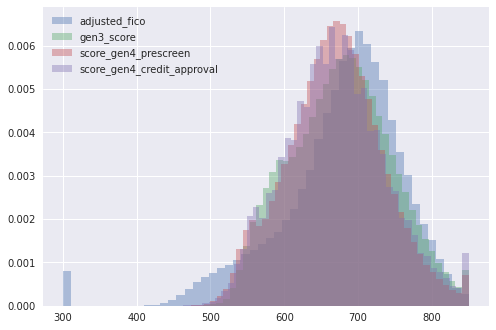

In [29]:
pred_cols = ["adjusted_fico", "gen3_score",
             "score_gen4_prescreen", "score_gen4_credit_approval"]
for p in pred_cols:
    df[p].hist(bins=50, label=p, alpha=0.4, density=True)

plt.legend()

In [30]:
pred_cols = ["adjusted_fico", "gen3_score",
             "score_gen4_prescreen", "score_gen4_credit_approval"]

df["inv_target"] = 1 - df[target]
test_df["inv_target"] = 1 - test_df[target]
metrics = get_pred_reports(test_df, "inv_target", pred_cols, sample_weight_col="weight_eval")
metrics["% inc in ks"] = metrics["ks"] / metrics.loc["gen3_score", "ks"]
metrics.sort_values("ks", inplace=True)
metrics

,auc,ap,ks,% inc in ks
adjusted_fico,0.7252,0.9293,32.87,0.874667
gen3_score,0.7546,0.9402,37.58,1.000000
score_gen4_prescreen,0.7665,0.9447,39.36,1.047366
score_gen4_credit_approval,0.7726,0.9463,40.55,1.079031


In [31]:
# train vs test

tr_metrics = get_pred_reports(df, "inv_target", pred_cols, sample_weight_col="weight_eval")
tr_metrics["% inc in ks"] = tr_metrics["ks"] / tr_metrics.loc["gen3_score", "ks"]
tr_metrics["type"] = "train"

ts_metrics = get_pred_reports(test_df, "inv_target", pred_cols, sample_weight_col="weight_eval")
ts_metrics["% inc in ks"] = ts_metrics["ks"] / ts_metrics.loc["gen3_score", "ks"]
ts_metrics["type"] = "test"

In [32]:
metrics_pair = pd.concat([tr_metrics, ts_metrics]).pivot(index=None, # current index
                                             columns=["type"])
col_order = metrics_pair.columns.sort_values(ascending=False)
metrics_pair[col_order]

ks            auc              ap          \
type                        train   test   train    test   train    test   
adjusted_fico               31.78  32.87  0.7181  0.7252  0.9204  0.9293   
gen3_score                  36.80  37.58  0.7492  0.7546  0.9327  0.9402   
score_gen4_credit_approval  39.92  40.55  0.7683  0.7726  0.9398  0.9463   
score_gen4_prescreen        38.58  39.36  0.7609  0.7665  0.9375  0.9447   

                           % inc in ks            
type                             train      test  
adjusted_fico                 0.863587  0.874667  
gen3_score                    1.000000  1.000000  
score_gen4_credit_approval    1.084783  1.079031  
score_gen4_prescreen          1.048370  1.047366

In [33]:
len(model.feature_name_)

31

In [34]:
print(f"===================== overall =====================")
metrics = get_pred_reports(test_df, "inv_target", pred_cols, sample_weight_col="weight_eval")
metrics["% inc in ks"] = metrics["ks"] / metrics.loc["gen3_score", "ks"]
metrics.sort_values("auc", inplace=True)
display(metrics)

for ris in ["booked", "proxy", "others"]:
    print(f"===================== {ris} =====================")
    df_ = test_df[test_df.ri_source == ris]
    metrics = get_pred_reports(df_, "inv_target", pred_cols, sample_weight_col="weight_eval")
    metrics["% inc in ks"] = metrics["ks"] / metrics.loc["gen3_score", "ks"]
    metrics.sort_values("auc", inplace=True)
    metrics
    display(metrics)

===================== overall =====================


,auc,ap,ks,% inc in ks
adjusted_fico,0.7252,0.9293,32.87,0.874667
gen3_score,0.7546,0.9402,37.58,1.000000
score_gen4_prescreen,0.7665,0.9447,39.36,1.047366
score_gen4_credit_approval,0.7726,0.9463,40.55,1.079031


===================== booked =====================


,auc,ap,ks,% inc in ks
adjusted_fico,0.6161,0.9665,16.90,0.564462
gen3_score,0.7023,0.9765,29.94,1.000000
score_gen4_prescreen,0.7295,0.9794,33.38,1.114896
score_gen4_credit_approval,0.7366,0.9801,34.62,1.156313


===================== proxy =====================


,auc,ap,ks,% inc in ks
adjusted_fico,0.6418,0.9366,20.49,0.720211
gen3_score,0.6950,0.9498,28.45,1.000000
score_gen4_prescreen,0.7114,0.9541,30.44,1.069947
score_gen4_credit_approval,0.7192,0.9551,32.43,1.139895


===================== others =====================


,auc,ap,ks,% inc in ks
adjusted_fico,0.7170,0.9140,31.73,0.878947
gen3_score,0.7446,0.9257,36.10,1.000000
score_gen4_prescreen,0.7566,0.9309,37.98,1.052078
score_gen4_credit_approval,0.7627,0.9330,39.05,1.081717


In [29]:
# test_df.period.value_counts()

print(f"===================== overall =====================")
metrics = get_pred_reports(test_df, "inv_target", pred_cols, sample_weight_col="weight_eval")
metrics["% inc in ks"] = metrics["ks"] / metrics.loc["gen3_score", "ks"]
metrics.sort_values("auc", inplace=True)
display(metrics)

for p in ["oot18q1", "oot19q2"]:
    print(f"===================== full {p} =====================")
    df_ = test_df[test_df.period == p]
    metrics = get_pred_reports(df_, "inv_target", pred_cols, sample_weight_col="weight_eval")
    metrics["% inc in ks"] = metrics["ks"] / metrics.loc["gen3_score", "ks"]
    metrics.sort_values("auc", inplace=True)
    metrics
    display(metrics)
    
for p in ["oot18q1", "oot19q2"]:
    print(f"===================== booked {p} =====================")
    df_ = test_df[(test_df.ri_source == "booked") & (test_df.period == p)]
    metrics = get_pred_reports(df_, "inv_target", pred_cols, sample_weight_col="weight_eval")
    metrics["% inc in ks"] = metrics["ks"] / metrics.loc["gen3_score", "ks"]
    metrics.sort_values("auc", inplace=True)
    metrics
    display(metrics)

===================== overall =====================


,auc,ap,ks,% inc in ks
adjusted_fico,0.7252,0.9293,32.87,0.874667
gen3_score,0.7546,0.9402,37.58,1.000000
score_gen4_prescreen,0.7665,0.9447,39.36,1.047366
score_gen4_credit_approval,0.7726,0.9463,40.55,1.079031


===================== full oot18q1 =====================


,auc,ap,ks,% inc in ks
adjusted_fico,0.7129,0.9234,30.92,0.861281
gen3_score,0.7430,0.9345,35.90,1.000000
score_gen4_prescreen,0.7562,0.9395,37.79,1.052646
score_gen4_credit_approval,0.7630,0.9414,39.03,1.087187


===================== full oot19q2 =====================


,auc,ap,ks,% inc in ks
adjusted_fico,0.7380,0.9350,35.07,0.889876
gen3_score,0.7668,0.9459,39.41,1.000000
score_gen4_prescreen,0.7773,0.9497,41.06,1.041868
score_gen4_credit_approval,0.7826,0.9510,42.19,1.070540


===================== booked oot18q1 =====================


,auc,ap,ks,% inc in ks
adjusted_fico,0.6257,0.9641,18.55,0.607201
gen3_score,0.7051,0.9741,30.55,1.000000
score_gen4_prescreen,0.7279,0.9769,33.00,1.080196
score_gen4_credit_approval,0.7340,0.9776,34.33,1.123732


===================== booked oot19q2 =====================


,auc,ap,ks,% inc in ks
adjusted_fico,0.5904,0.9689,13.61,0.478551
gen3_score,0.6909,0.9790,28.44,1.000000
score_gen4_prescreen,0.7257,0.9821,33.16,1.165963
score_gen4_credit_approval,0.7345,0.9827,35.09,1.233826


#### detailed performance

In [30]:
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc
import scipy.stats.stats as stats
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import seaborn as sns
plt.style.use('ggplot')

def score_gain(Y,Y_weight,X,decile=10,diretion=0, ndigits=6):
    YY=Y.reset_index(drop=True)
    YY_weight=Y_weight.reset_index(drop=True)
    XX=X.reset_index(drop=True)
    
    bins=pd.qcut(XX,decile,retbins=False,labels=False,duplicates="drop")
    Y_bins=pd.DataFrame(bins,index=YY.index)
    Y_model=pd.DataFrame(XX,index=YY.index)
    Y_new=YY*YY_weight
        
    Y_final=pd.concat([Y_new,YY_weight,Y_model,Y_bins],axis=1) 
    Y_final.columns=['true','weight','score','bins']
    Y_final.loc[Y_final.score==0,'bins']=-99     
    s_min=round(Y_final.groupby('bins')['score'].min(),ndigits)
    s_max=round(Y_final.groupby('bins')['score'].max(),ndigits)
    s_count=Y_final.groupby('bins')['weight'].sum()
    s_pred=round(Y_final.groupby('bins')['score'].mean(),ndigits)
    #s_rate=round(Y_final.groupby('bins')['true'].mean(),ndigits)
    s_numtarget=round(Y_final.groupby('bins')['true'].sum(),1)
    s_rate=s_numtarget/s_count
    g_table=pd.concat([s_count,s_min,s_max,s_pred,s_rate,s_numtarget],axis=1)    
    g_table.columns=["#accts","min","max","pred_rate","actual_rate","target_num"]
        
    if diretion==1:
        g_table=g_table.sort_values(by="min",ascending=False)
    elif diretion==0:
        g_table=g_table.sort_values(by="min",ascending=True)
        
    g_table['nontarget_num']=g_table['#accts']-g_table['target_num']
        
    g_table['pct_cum_acct']=round(g_table['#accts'].cumsum()/g_table['#accts'].sum(),ndigits)
    g_table['pct_cum_target']=round(g_table['target_num'].cumsum()/g_table['target_num'].sum(),ndigits)
    g_table['pct_cum_nontarget']=round(g_table['nontarget_num'].cumsum()/g_table['nontarget_num'].sum(),ndigits)
    g_table['reverse_target_num']=g_table.target_num.values[::-1]
    g_table['reverse_total_num']=g_table['#accts'].values[::-1]
    g_table['cum_bads']=round(g_table['reverse_target_num'].cumsum()/g_table['reverse_total_num'].cumsum(),ndigits)
    g_table['cum_acct']=round(g_table['reverse_total_num'].cumsum()/g_table['reverse_total_num'].sum(),ndigits)
    g_table['KS']=(g_table['pct_cum_target'] - g_table['pct_cum_nontarget'])*100
        
    g_table.reset_index(inplace=True,drop=True)
    g_table=g_table[["pct_cum_acct","#accts","min","max","target_num",'pct_cum_target','pct_cum_nontarget',"actual_rate",'KS','cum_bads','cum_acct']]
        
    return g_table


# efficinet frontier ax4 
# bad rate by percentile ax1
# gains table: ax2
# overall

def plot_efficient_frontier(y_test, y_scores, sample_weight=None,
                            title='Efficient Frontier', colors=["b"], 
                            figsize=None, alpha=0.4, ax=None, fig=None,
                            decile=20,
                            **kwargs):
    
    assert(len(y_scores) == len(colors))
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    for i in range(len(y_scores)):
        y_score, label = y_scores[i]
        
        score_tbl = score_gain(y_test, sample_weight,
                               y_score, decile, diretion=1)
        ax.plot(score_tbl["cum_acct"], score_tbl["cum_bads"],
                label=label, color=colors[i], alpha=alpha)
        
    ax.set_xlabel('Approval Rate')
    ax.set_ylabel('Bad Rate')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax


def plot_percentile_bad_rate(y_test, y_scores, sample_weight=None,
                            title='Bad Rate by Percentile', colors=["b"], 
                            figsize=None, alpha=0.4, ax=None, fig=None,
                            decile=20, width=0.25,
                            **kwargs):
    assert(len(y_scores) == len(colors))
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    for i in range(len(y_scores)):
        y_score, label = y_scores[i]
        
        score_tbl = score_gain(y_test, sample_weight,
                               y_score, decile, diretion=1)
        
        loc = range(score_tbl.shape[0])
        loc = [l+i*width for l in loc]
        ax.bar(loc, score_tbl["actual_rate"], width=width, label=label,
               color=colors[i], alpha=alpha)
        
    ax.set_xlabel('Percentile')
    ax.set_ylabel('Bad Rate')
    
    xticks = range(score_tbl.shape[0])
    xlabels = [int((i+1)*100/decile) for i in range(score_tbl.shape[0])]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_title(title)
    ax.legend()
    
    return fig, ax


In [31]:
sg_tbl = score_gain(test_df[target], 
               test_df[weight_eval],
               test_df["pred_gen4_prescreen"],
               decile=20,
               diretion=1)
sg_tbl.to_csv(os.path.join(artifact_path, segment, "metrics_gains_table.csv"))
sg_tbl.head()

,pct_cum_acct,#accts,min,max,target_num,pct_cum_target,pct_cum_nontarget,actual_rate,KS,cum_bads,cum_acct
0,0.044469,28179.0,0.489259,0.912409,14212.9,0.149016,0.025945,0.504379,12.3071,0.011979,0.053615
1,0.089589,28592.0,0.378756,0.489253,11498.7,0.269574,0.057699,0.402165,21.1875,0.015966,0.107313
2,0.135505,29096.0,0.309653,0.378754,9572.7,0.369939,0.093967,0.329004,27.5972,0.020617,0.160658
3,0.182140,29552.0,0.260591,0.309653,8282.9,0.456782,0.133478,0.280282,32.3304,0.025464,0.213728
4,0.229702,30139.0,0.222682,0.260590,7158.8,0.531838,0.176168,0.237526,35.5670,0.030208,0.266435


In [32]:
score_tbls = {}

df_ = test_df
preds = [
    (df_['pred_gen4_credit_approval'], 'gen4_credit_approval'),
    (df_['pred_gen4_prescreen'], 'gen4_prescreen'),
    (df_['pred_gen3'], 'pred_gen3'),
]
y_test = df_[target]
sample_weight = df_[weight_eval]
decile = 100

for y_score, label in preds:
    score_tbls[label] = score_gain(y_test, sample_weight,
                                   y_score, decile, diretion=1)
    score_tbls[label]["model"] = label
    display(score_tbls[label].head())


,pct_cum_acct,#accts,min,max,target_num,pct_cum_target,pct_cum_nontarget,actual_rate,KS,cum_bads,cum_acct,model
0,0.008876,5624.5,0.607361,0.939551,3055.8,0.032039,0.004772,0.543302,2.7267,0.004892,0.010999,gen4_credit_approval
1,0.017767,5634.0,0.560647,0.607350,2956.2,0.063033,0.009746,0.524707,5.3287,0.006675,0.022176,gen4_credit_approval
2,0.026660,5635.5,0.529913,0.560639,2824.4,0.092645,0.014968,0.501180,7.7677,0.007958,0.033215,gen4_credit_approval
3,0.035537,5625.5,0.506353,0.529906,2775.0,0.121740,0.020264,0.493289,10.1476,0.009336,0.044251,gen4_credit_approval
4,0.044453,5649.5,0.484457,0.506349,2620.1,0.149210,0.025891,0.463776,12.3319,0.010242,0.055267,gen4_credit_approval


,pct_cum_acct,#accts,min,max,target_num,pct_cum_target,pct_cum_nontarget,actual_rate,KS,cum_bads,cum_acct,model
0,0.008889,5633.0,0.606703,0.912409,3060.4,0.032087,0.004779,0.543298,2.7308,0.006196,0.010646,gen4_prescreen
1,0.017764,5623.5,0.566506,0.606703,2893.8,0.062427,0.009850,0.514591,5.2577,0.009068,0.021459,gen4_prescreen
2,0.026647,5629.5,0.538230,0.566501,2840.9,0.092213,0.015030,0.504645,7.7183,0.009595,0.032202,gen4_prescreen
3,0.035551,5642.0,0.512325,0.538228,2738.5,0.120925,0.020424,0.485378,10.0501,0.010720,0.042955,gen4_prescreen
4,0.044469,5651.0,0.489259,0.512323,2679.3,0.149016,0.025945,0.474128,12.3071,0.011979,0.053615,gen4_prescreen


,pct_cum_acct,#accts,min,max,target_num,pct_cum_target,pct_cum_nontarget,actual_rate,KS,cum_bads,cum_acct,model
0,0.008582,5438.0,-538.0,-431.0,2829.9,0.029670,0.004845,0.520394,2.4825,0.011078,0.010655,pred_gen3
1,0.016960,5309.0,-547.0,-539.0,2620.1,0.057141,0.009840,0.493520,4.7301,0.012633,0.021973,pred_gen3
2,0.026212,5863.0,-554.0,-548.0,2763.0,0.086109,0.015599,0.471260,7.0510,0.013700,0.032828,pred_gen3
3,0.034112,5006.0,-559.0,-555.0,2303.5,0.110261,0.020619,0.460148,8.9642,0.014999,0.043052,pred_gen3
4,0.043372,5868.0,-564.0,-560.0,2591.0,0.137426,0.026707,0.441547,11.0719,0.016223,0.053733,pred_gen3


In [33]:
# find bad rate with same approving rate
# how much bad can we reduce with fixed approval rate
col = "cum_acct"
val = 0.6

tbl = pd.concat(score_tbls)
tbl["distance_"] = (tbl[col] - val).abs()
tbl.sort_values("distance_", inplace=True)
tbl = tbl.groupby("model").head(1)[["model", "cum_acct", "cum_bads"]]
tbl

,,model,cum_acct,cum_bads
pred_gen3,56,pred_gen3,0.600895,0.070734
gen4_credit_approval,56,gen4_credit_approval,0.596663,0.063881
gen4_prescreen,57,gen4_prescreen,0.604659,0.067528


In [34]:
# find number accounts with same bad rate
# - how many more applications can we approve maintaining br
col = "cum_bads"
val = 0.053

tbl = pd.concat(score_tbls)
tbl["distance_"] = (tbl[col] - val).abs()
tbl.sort_values("distance_", inplace=True)
tbl = tbl.groupby("model").head(1)[["model", "cum_acct", "cum_bads"]]
tbl

,,model,cum_acct,cum_bads
gen4_prescreen,45,gen4_prescreen,0.483968,0.052876
pred_gen3,40,pred_gen3,0.437215,0.052645
gen4_credit_approval,47,gen4_credit_approval,0.506947,0.052486


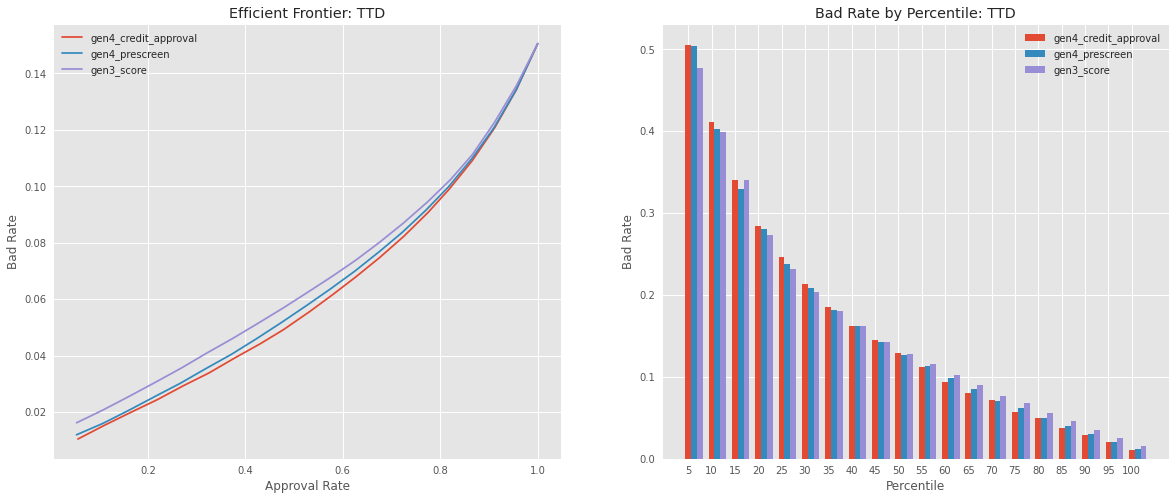

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
df_ = test_df.copy()

preds = [
    (-df_['score_gen4_credit_approval'], 'gen4_credit_approval'),
    (-df_['score_gen4_prescreen'], 'gen4_prescreen'),
    (-df_['gen3_score'], 'gen3_score'),
]
y_test = df_[target]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'Efficient Frontier: TTD'

plot_efficient_frontier(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                        lw=2, ax=axs[0]
                        )

title = 'Bad Rate by Percentile: TTD'
plot_percentile_bad_rate(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                         ax=axs[1]
                        )

plt.savefig(os.path.join(local_artifact_path, "perf-efficient-frontier-br-pct.png"))

No handles with labels found to put in legend.


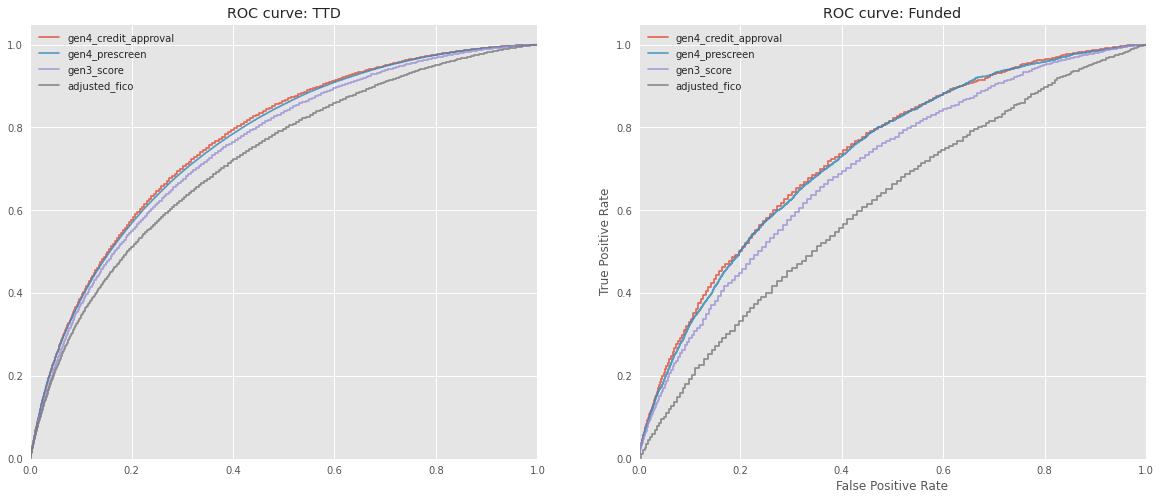

In [36]:
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult


fig, axs = plt.subplots(1, 2, figsize=(20,8))
df_ = test_df

preds = [
    (-df_['score_gen4_credit_approval'], 'gen4_credit_approval'),
    (-df_['score_gen4_prescreen'], 'gen4_prescreen'),
    (-df_['gen3_score'], 'gen3_score'),
    (-df_['adjusted_fico'], 'adjusted_fico'),
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'ROC curve: TTD'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[0])
axs[0].legend()

df_ = test_df[test_df.ri_source=="booked"]

preds = [
    (-df_['score_gen4_credit_approval'], 'gen4_credit_approval'),
    (-df_['score_gen4_prescreen'], 'gen4_prescreen'),
    (-df_['gen3_score'], 'gen3_score'),
    (-df_['adjusted_fico'], 'adjusted_fico'),
]

title = 'ROC curve: Funded'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[1])
axs[1].legend()

plt.savefig(os.path.join(local_artifact_path, "perf-roc-ttd-vs-funded.png"))

#### Performance by period
---

In [37]:
# make sure it won't mess up test data

In [38]:
test_df.shape

(1150725, 61)

No handles with labels found to put in legend.


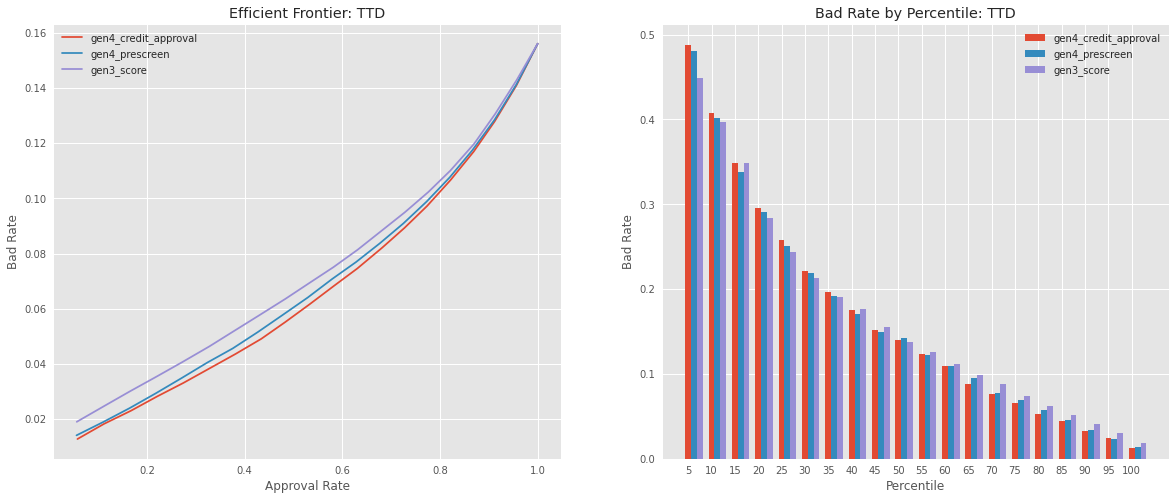

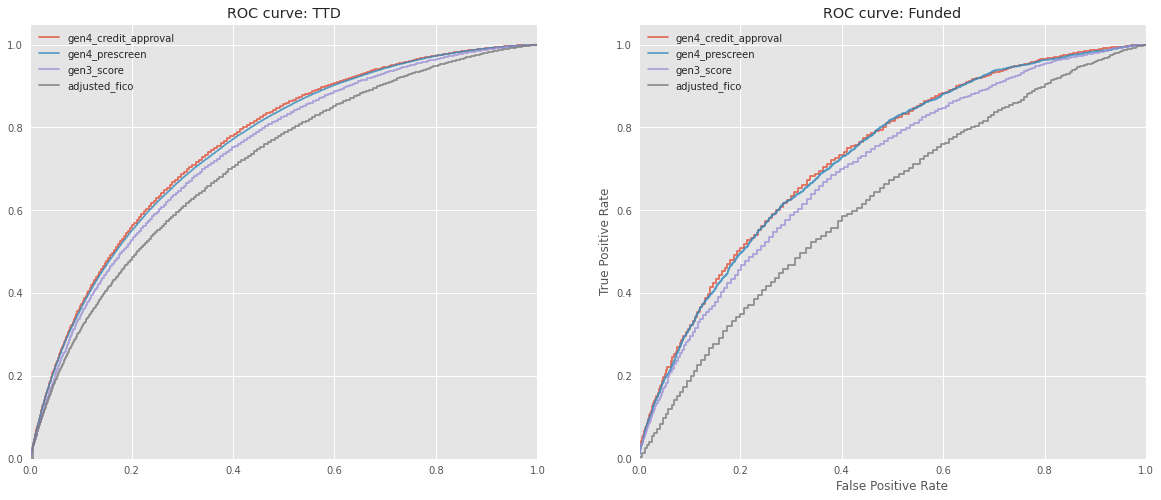

In [39]:
period = "oot18q1"
fig, axs = plt.subplots(1, 2, figsize=(20,8))
df_ = test_df[test_df.period == period]
preds = [
    (-df_['score_gen4_credit_approval'], 'gen4_credit_approval'),
    (-df_['score_gen4_prescreen'], 'gen4_prescreen'),
    (-df_['gen3_score'], 'gen3_score'),
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'Efficient Frontier: TTD'

plot_efficient_frontier(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                        lw=2, ax=axs[0]
                        )

title = 'Bad Rate by Percentile: TTD'
plot_percentile_bad_rate(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                         ax=axs[1]
                        )

plt.savefig(os.path.join(local_artifact_path, f"perf-efficient-frontier-br-pct_{period}.png"))


fig, axs = plt.subplots(1, 2, figsize=(20,8))
df_ = test_df[test_df.period == period]

preds = [
    (-df_['score_gen4_credit_approval'], 'gen4_credit_approval'),
    (-df_['score_gen4_prescreen'], 'gen4_prescreen'),
    (-df_['gen3_score'], 'gen3_score'),
    (-df_['adjusted_fico'], 'adjusted_fico'),
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'ROC curve: TTD'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[0])
axs[0].legend()

df_ = test_df[(test_df.ri_source=="booked")
             & (test_df.period==period)]

preds = [
    (-df_['score_gen4_credit_approval'], 'gen4_credit_approval'),
    (-df_['score_gen4_prescreen'], 'gen4_prescreen'),
    (-df_['gen3_score'], 'gen3_score'),
    (-df_['adjusted_fico'], 'adjusted_fico'),
]

title = 'ROC curve: Funded'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[1])
axs[1].legend()

plt.savefig(os.path.join(local_artifact_path, f"perf-roc-ttd-vs-funded_{period}.png"))

No handles with labels found to put in legend.


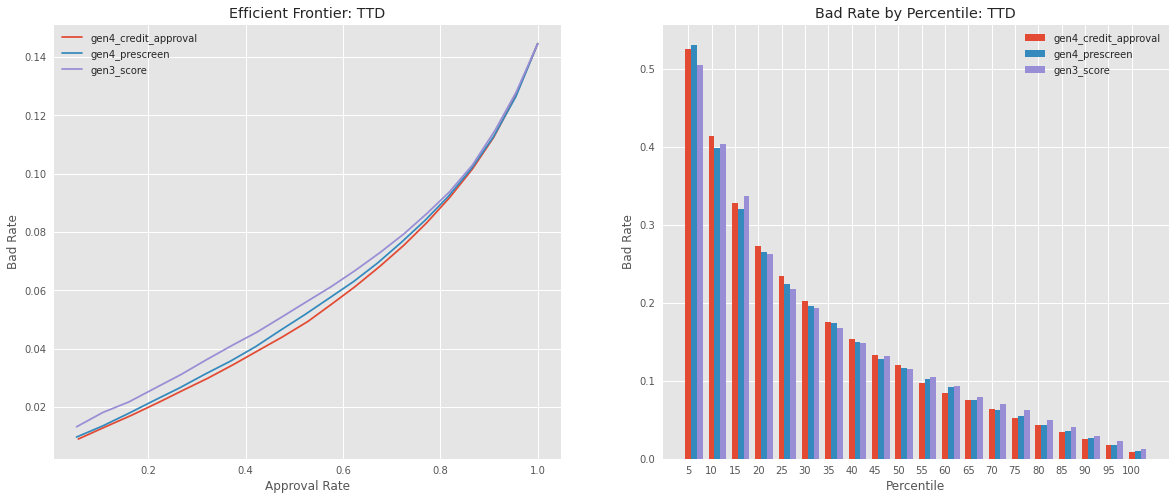

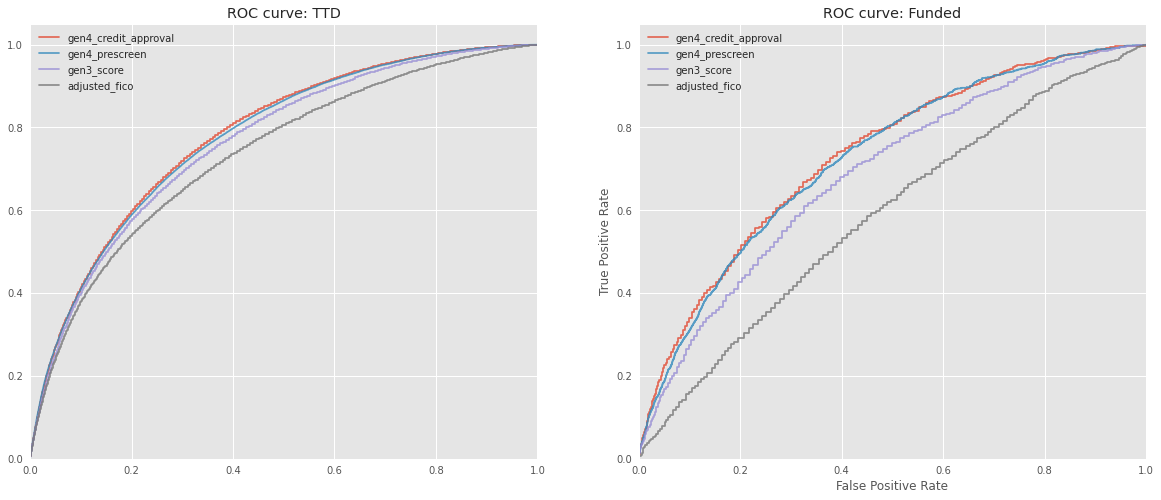

In [40]:
period = "oot19q2"
fig, axs = plt.subplots(1, 2, figsize=(20,8))
df_ = test_df[test_df.period == period]
preds = [
    (-df_['score_gen4_credit_approval'], 'gen4_credit_approval'),
    (-df_['score_gen4_prescreen'], 'gen4_prescreen'),
    (-df_['gen3_score'], 'gen3_score'),
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'Efficient Frontier: TTD'

plot_efficient_frontier(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                        lw=2, ax=axs[0]
                        )

title = 'Bad Rate by Percentile: TTD'
plot_percentile_bad_rate(df_[target], preds,
                        sample_weight=df_["weight_eval"],
                        title=title, colors=colors, alpha=1,
                         ax=axs[1]
                        )

plt.savefig(os.path.join(local_artifact_path, f"perf-efficient-frontier-br-pct_{period}.png"))


fig, axs = plt.subplots(1, 2, figsize=(20,8))
df_ = test_df[test_df.period == period]

preds = [
    (-df_['score_gen4_credit_approval'], 'gen4_credit_approval'),
    (-df_['score_gen4_prescreen'], 'gen4_prescreen'),
    (-df_['gen3_score'], 'gen3_score'),
    (-df_['adjusted_fico'], 'adjusted_fico'),
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'ROC curve: TTD'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[0])
axs[0].legend()

df_ = test_df[(test_df.ri_source=="booked")
             & (test_df.period==period)]

preds = [
    (-df_['score_gen4_credit_approval'], 'gen4_credit_approval'),
    (-df_['score_gen4_prescreen'], 'gen4_prescreen'),
    (-df_['gen3_score'], 'gen3_score'),
    (-df_['adjusted_fico'], 'adjusted_fico'),
]

title = 'ROC curve: Funded'
plot_auc_curve_mult(df_[target], preds,
                    sample_weight=df_["weight_eval"],
                    title=title, colors=colors,
                    fill_area=False,
                    lw=2,
                    alpha=0.8,
                    ax=axs[1])
axs[1].legend()

plt.savefig(os.path.join(local_artifact_path, f"perf-roc-ttd-vs-funded_{period}.png"))

In [41]:
test_df.shape

(1150725, 61)

#### Feature Importance
---

In [43]:
import seaborn as sns

def display_feature_importance(features, importances, max_n_features=20, 
                               figsize=(9, 7), title=None, **kwargs):
    """Display feature importance given features
    and their importance.
    
    Parameters
    ----------
    features: pd.Series, np.ndarray - shape[n]
        Features.
    importances : pd.Series, np.ndarray - shape [n]
        Importance of respective feature.
    max_n_features : int
        Number of features to display.
    figsize : tuple (width, height)
        Size of figure to be produced.
    title : str
        Title of the axis.
    kwargs : keyword arguments
        Any keyword argument that can be passed to sns.barplot.
        
    Returns
    -------
    fig:
        matplotlib figure
    ax:
        matplotlib axis

    Notes
    -----
    This function is a tragedy. 
    TODO: make this better.
    """
    feature_importance_df = pd.DataFrame({'feature':features,
                                          'importance':importances})
    fi_grouped_mean = feature_importance_df.groupby('feature').mean()
    cols = fi_grouped_mean.sort_values(by='importance', ascending=False)\
                                       [:max_n_features].index
    fi_df = feature_importance_df.loc[feature_importance_df['feature']\
                                      .isin(cols)]\
                                      .sort_values(by='importance', 
                                                   ascending=False)
    
    sns.barplot(x="importance", y="feature", data=fi_df, **kwargs)
    return 

In [44]:
shap_

,shap
p13_bcc5520,0.286314
t11_tmti2752,0.172915
t11_tstu2752,0.137469
p13_iqz9420,0.131493
t11_tall3205,0.119939
p13_bcc8322,0.107083
t11_tbca4504,0.098092
p13_upl8132,0.088360
t11_trev0722,0.080507
p13_all7936,0.078745


Text(0.5, 1.0, 'LGBM Shap Value')

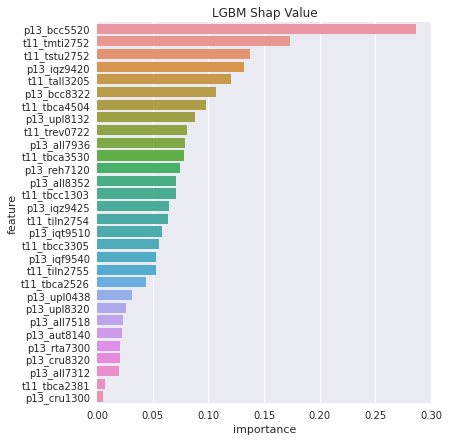

In [45]:
fig, axs = plt.subplots(ncols=1, figsize=(6, 7))
display_feature_importance(shap_.index,
                           shap_.shap,
                           max_n_features=-1,
                           ax=axs,
                           title="LGBM Shap Value")
axs.set_title("LGBM Shap Value")

#### Model Splits
---

In [55]:
def plot_lgbm_splits(df, lgbm, features, ncols=6, figsize=None, 
                     impute_missing_dict=None, fig=None, axs=None,
                     **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    import math
    nrows = math.ceil(len(features) / ncols)
    
    if isinstance(lgbm, lgb.LGBMModel):
        lgbm = lgbm.booster_ 
        
    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    if fig is None and axs is None:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for feature, ax in zip(features, axs.flatten()):
        ax = lgb.plot_split_value_histogram(lgbm, 
                        feature, label="tree splits",
                        ax=ax, title=feature)
        
        obs_min = df[feature].min()
        obs_max = df[feature].max()
        ax.axvline(x=obs_min, color="grey", linestyle="--", label=f"observed min : {obs_min:.2f}")
        ax.axvline(x=obs_max, color="grey", linestyle="--", label=f"observed max : {obs_max:.2f}")
        
        if impute_missing_dict:
            imp_val = impute_missing_dict[feature]
            ax.axvline(x=imp_val, color="grey", linestyle=":", label=f"imputed value: {imp_val:.2f}")
        
        split_vals = lgbm.get_split_value_histogram(feature)[1]
        split_min, split_max = split_vals.min(), split_vals.max()
        
        ax.plot([],[],' ',label=f"split min : {split_min:.2f}")
        ax.plot([],[],' ',label=f"split max : {split_max:.2f}")
        
        ax.legend()
        
    fig.supxlabel("Split Histogram for LGBM", fontsize=26)
    # fig.supylabel("")
    return fig, axs

CPU times: user 1min 46s, sys: 4.64 s, total: 1min 50s
Wall time: 1min 43s


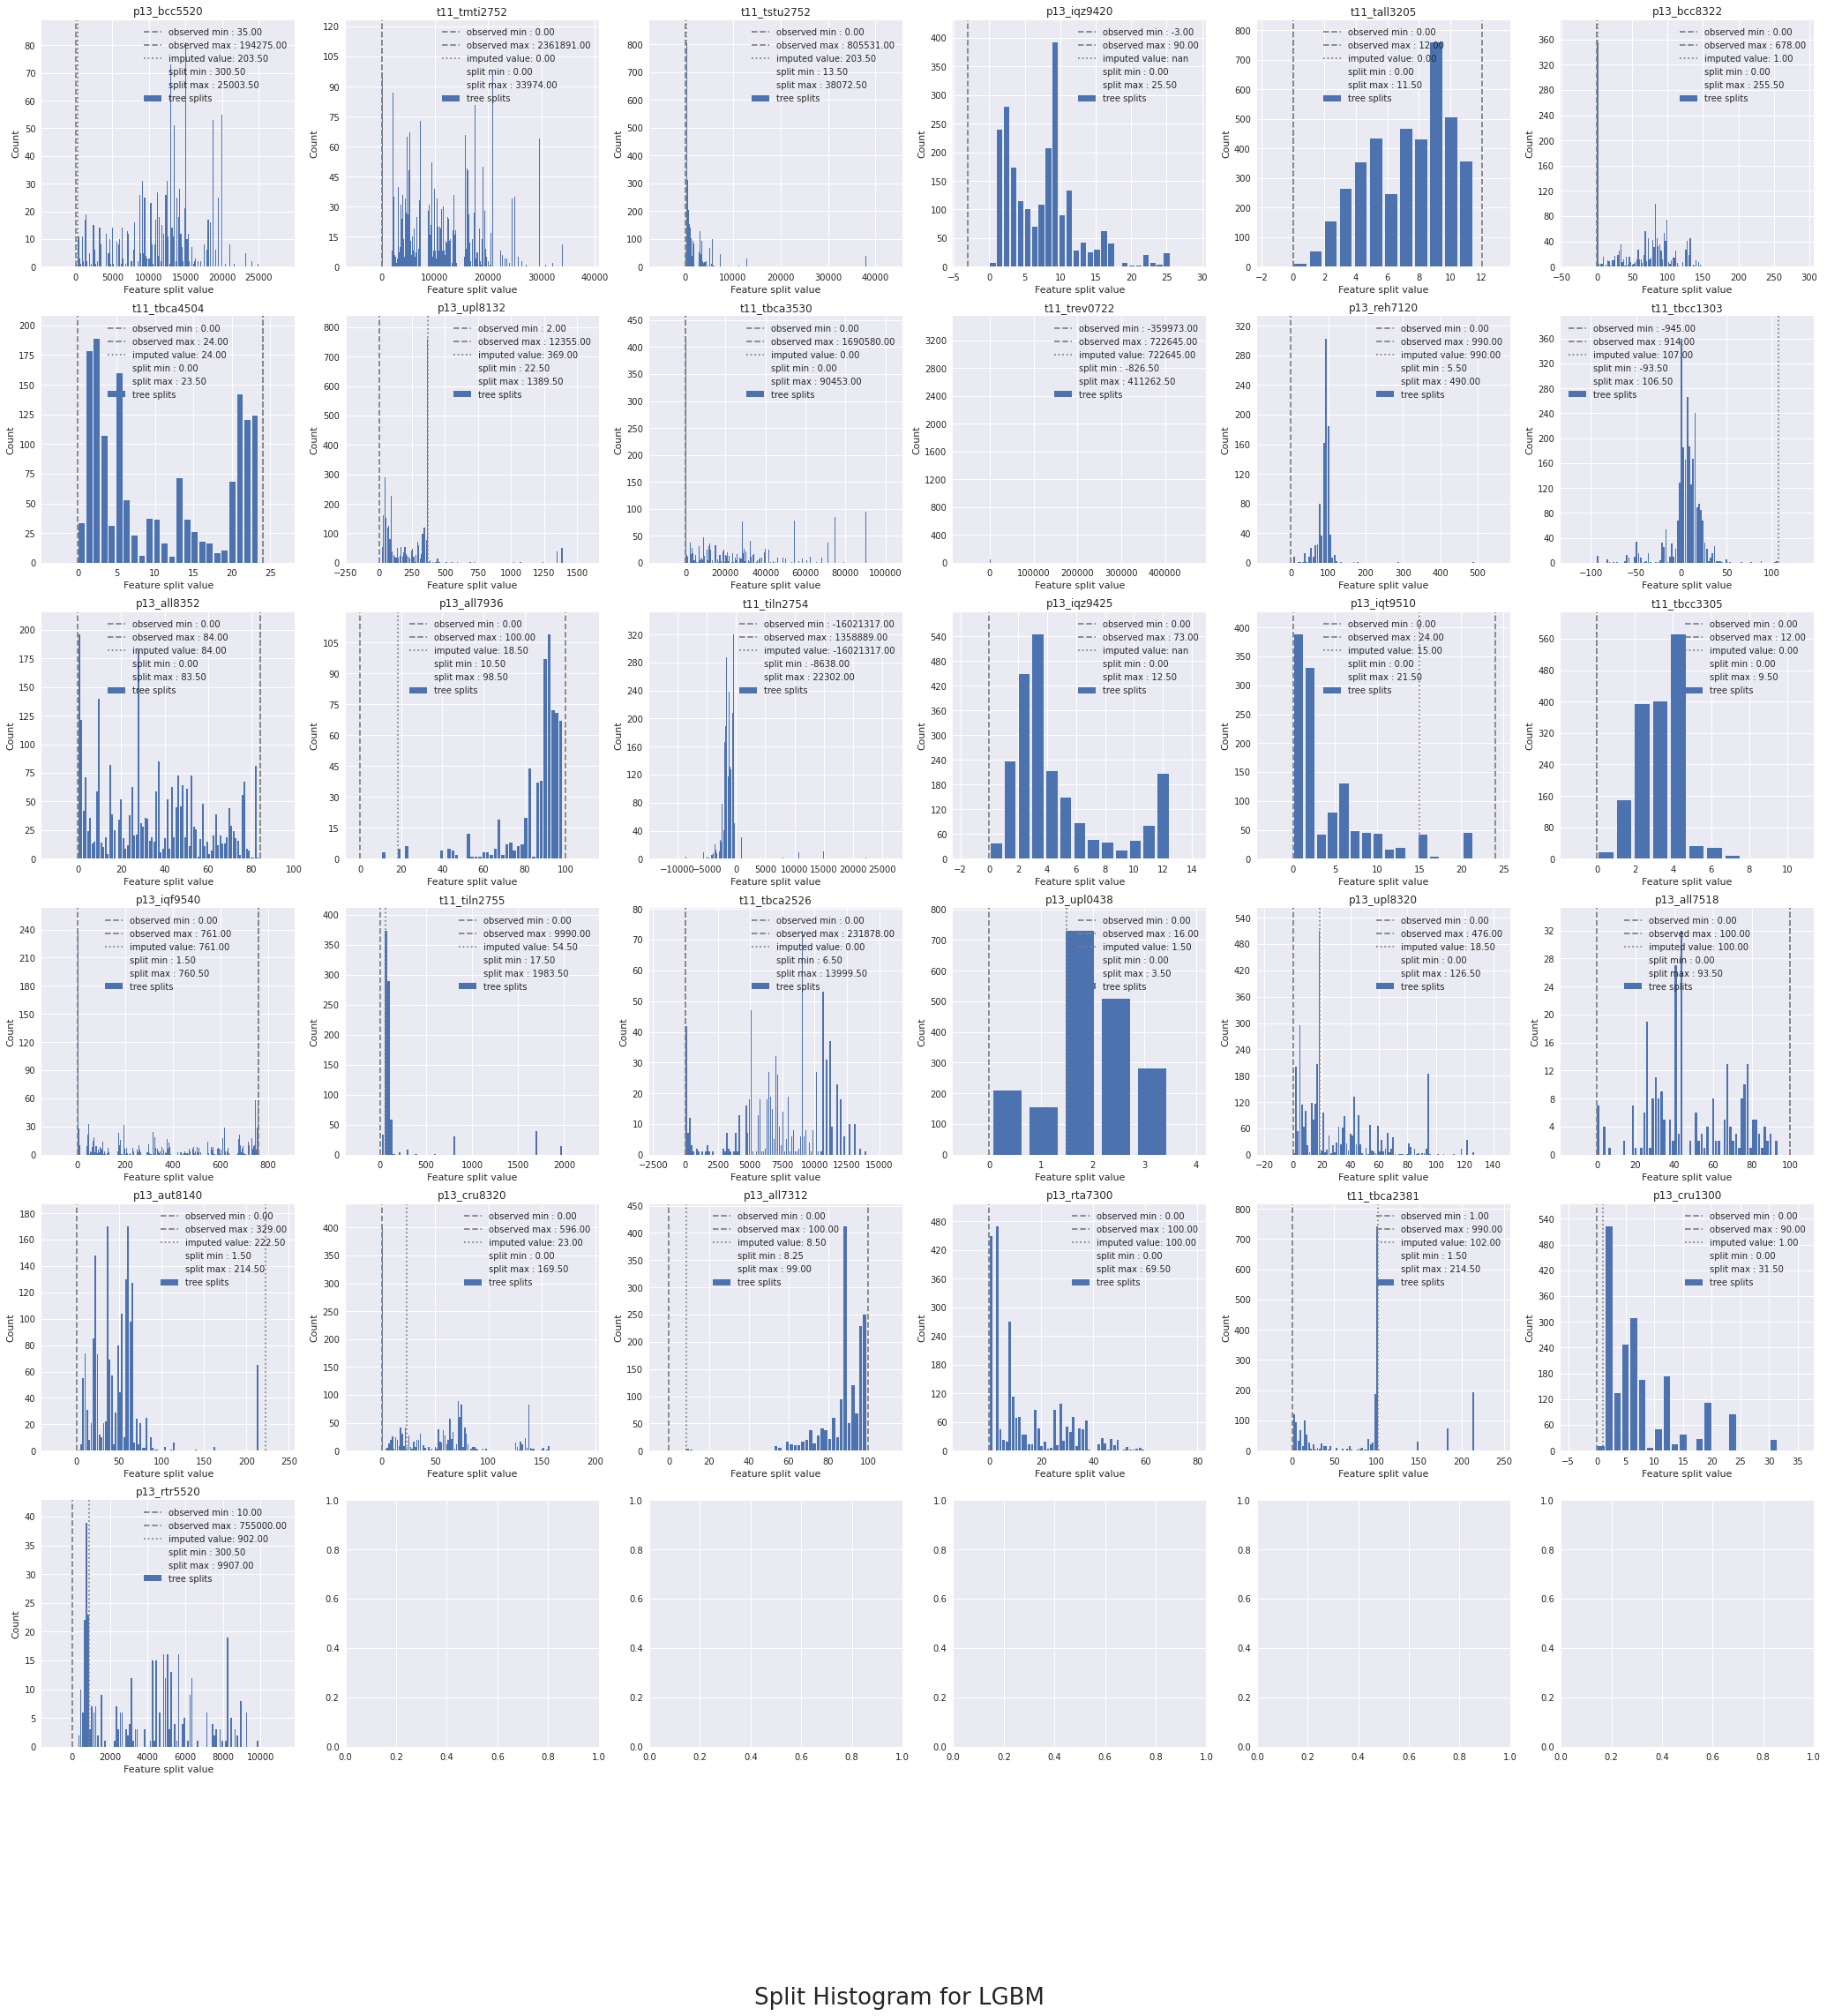

In [56]:
%%time

shap_ = shap_vals.rename("shap").to_frame()
ft_by_shap = shap_.sort_values("shap", ascending=False).index.to_list()
fig, axs = plot_lgbm_splits(df_unimp, model, ft_by_shap, impute_missing_dict=imp_mapper)

#### Shap and PDP
---

In [34]:
%%time
# pdp
import shap
from src.utils.governance import get_pdp, get_shap_dependence, pickle_obj

def save_pdp(model, modeling_df, features, 
             features_plot_order, dir_path, suffix="", ncols=3):
    
    os.makedirs(dir_path, exist_ok=True)
    fig = get_pdp(modeling_df[features], features, model,
                  features_plot_order, ncols=ncols)
    fig.savefig(os.path.join(dir_path, f"pdp{suffix}.png"))


def save_shap_dependence(model, modeling_df, features, dir_path, suffix="",
                         ncols=6):    
    os.makedirs(dir_path, exist_ok=True)
    shap.initjs()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(modeling_df[model.feature_name_])
    
    pickle_obj(shap_values, os.path.join(dir_path, f"shap_values{suffix}.pkl"))
    
    fig = get_shap_dependence(modeling_df[model.feature_name_], 
                              shap_values[1], features, 
                              interaction_index=None, ncols=ncols)
    
    fig.savefig(os.path.join(dir_path, f"shap_dependence{suffix}.png"))


CPU times: user 28 µs, sys: 1 µs, total: 29 µs
Wall time: 48.9 µs


31it [01:59,  3.86s/it]


CPU times: user 2h 57min 35s, sys: 1.75 s, total: 2h 57min 37s
Wall time: 2min 1s


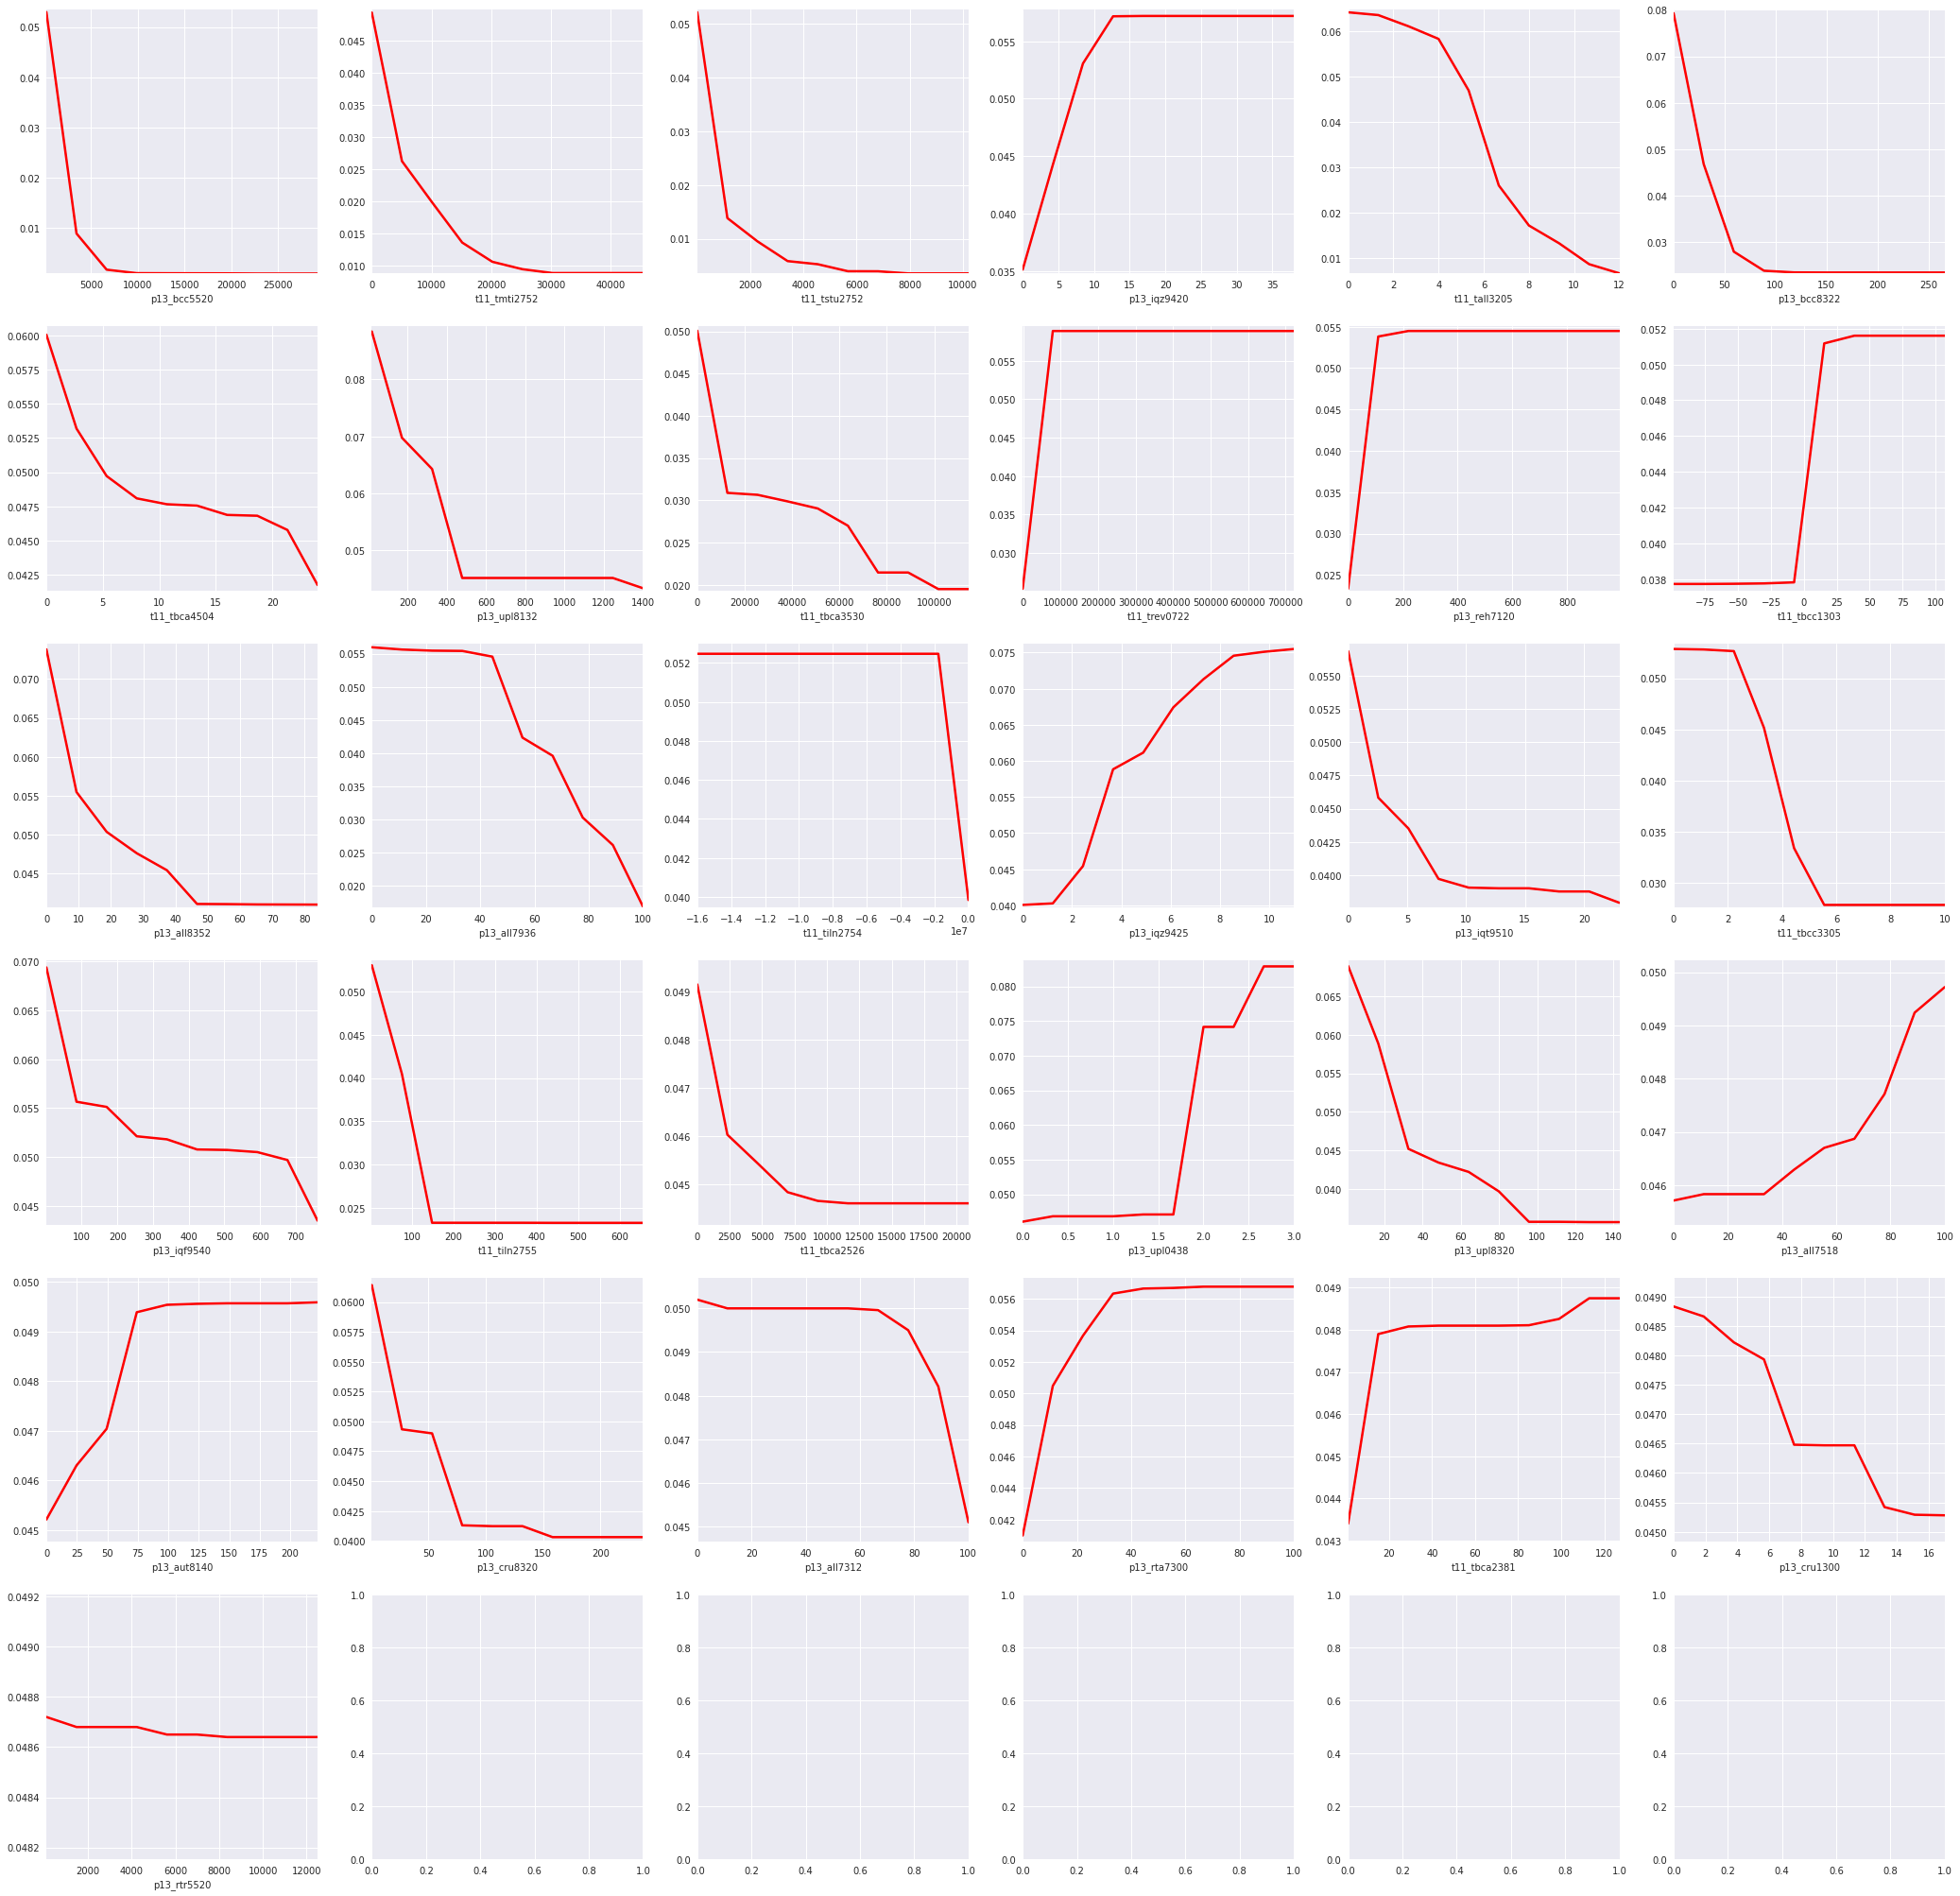

In [58]:
%time save_pdp(model, sample_df, model.feature_name_, ft_by_shap, local_artifact_path, suffix="")

31it [01:59,  3.86s/it]


CPU times: user 2h 57min 3s, sys: 1.5 s, total: 2h 57min 5s
Wall time: 2min 1s


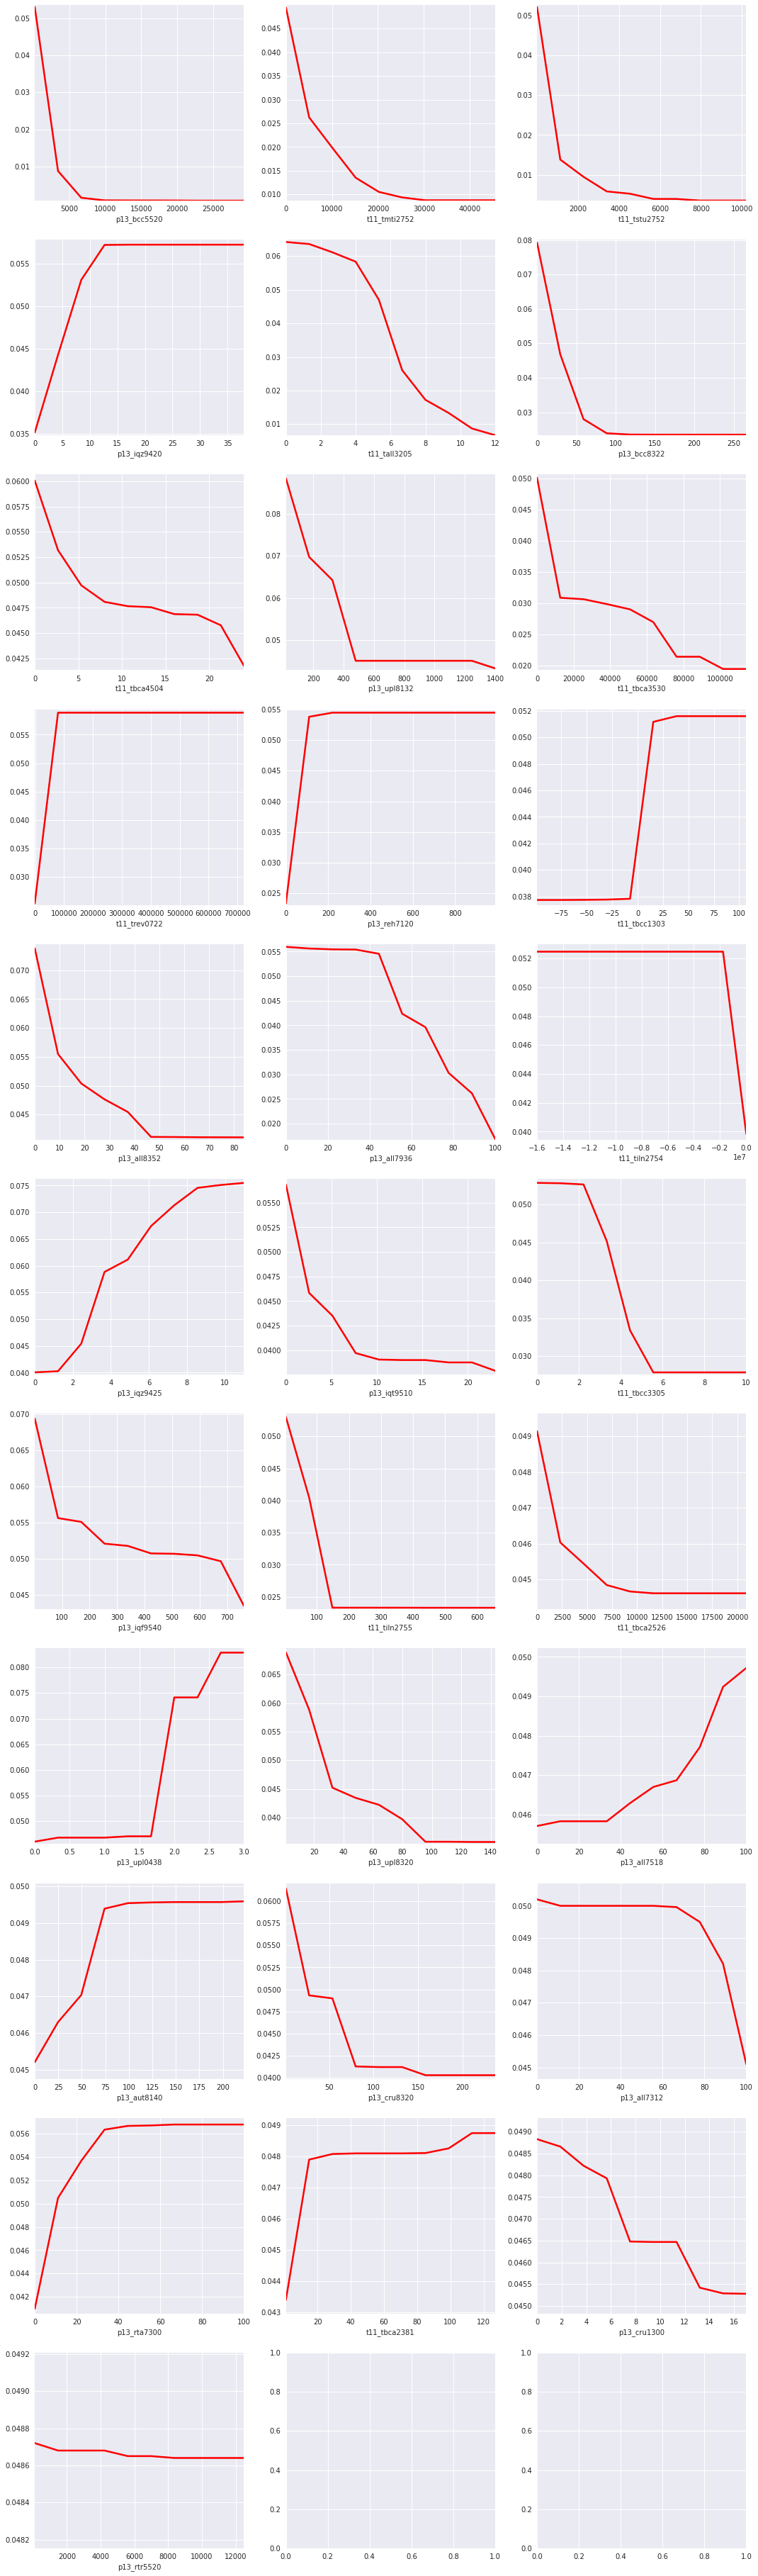

In [39]:
%time save_pdp(model, sample_df, model.feature_name_, ft_by_shap, local_artifact_path, suffix="_3arow", ncols=3)

CPU times: user 37min 53s, sys: 286 ms, total: 37min 53s
Wall time: 30.8 s


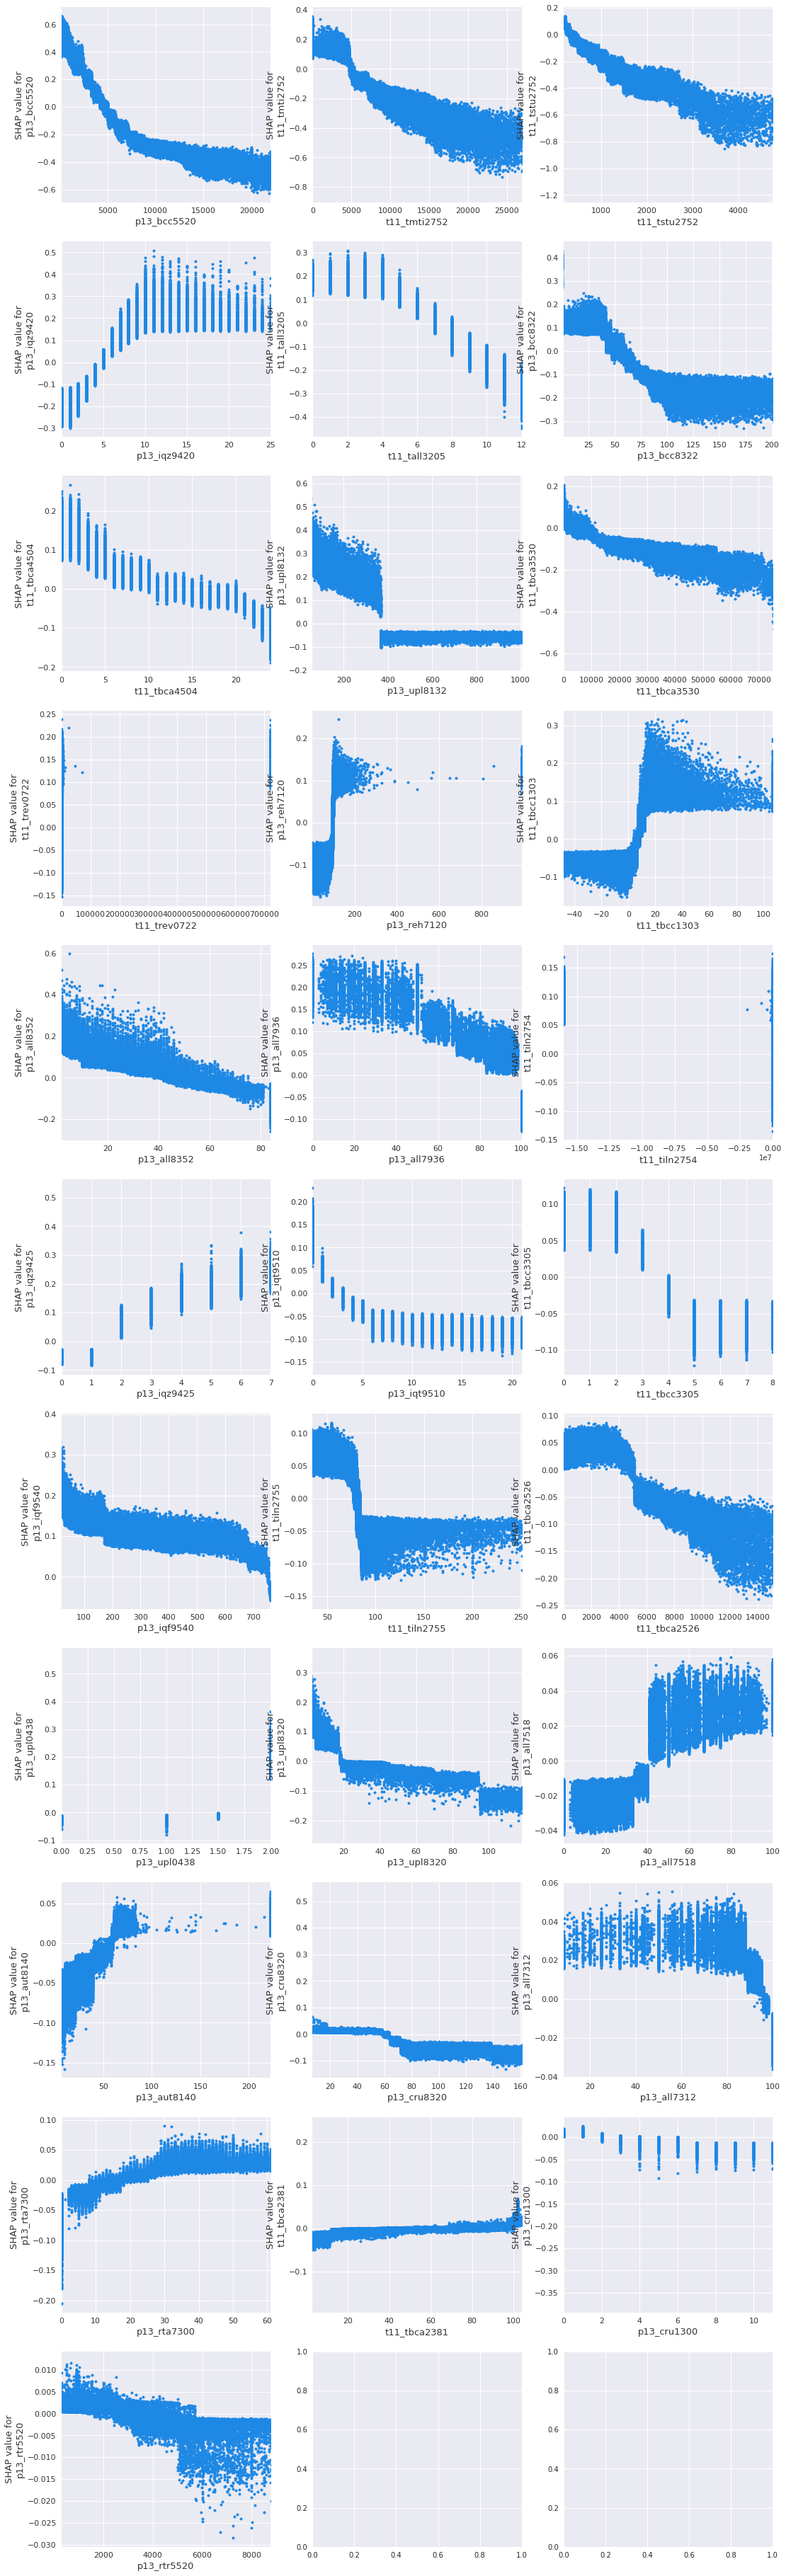

In [38]:
%time save_shap_dependence(model, sample_df, ft_by_shap, local_artifact_path, suffix="_3arow", ncols=3)

CPU times: user 37min 56s, sys: 286 ms, total: 37min 56s
Wall time: 34.2 s


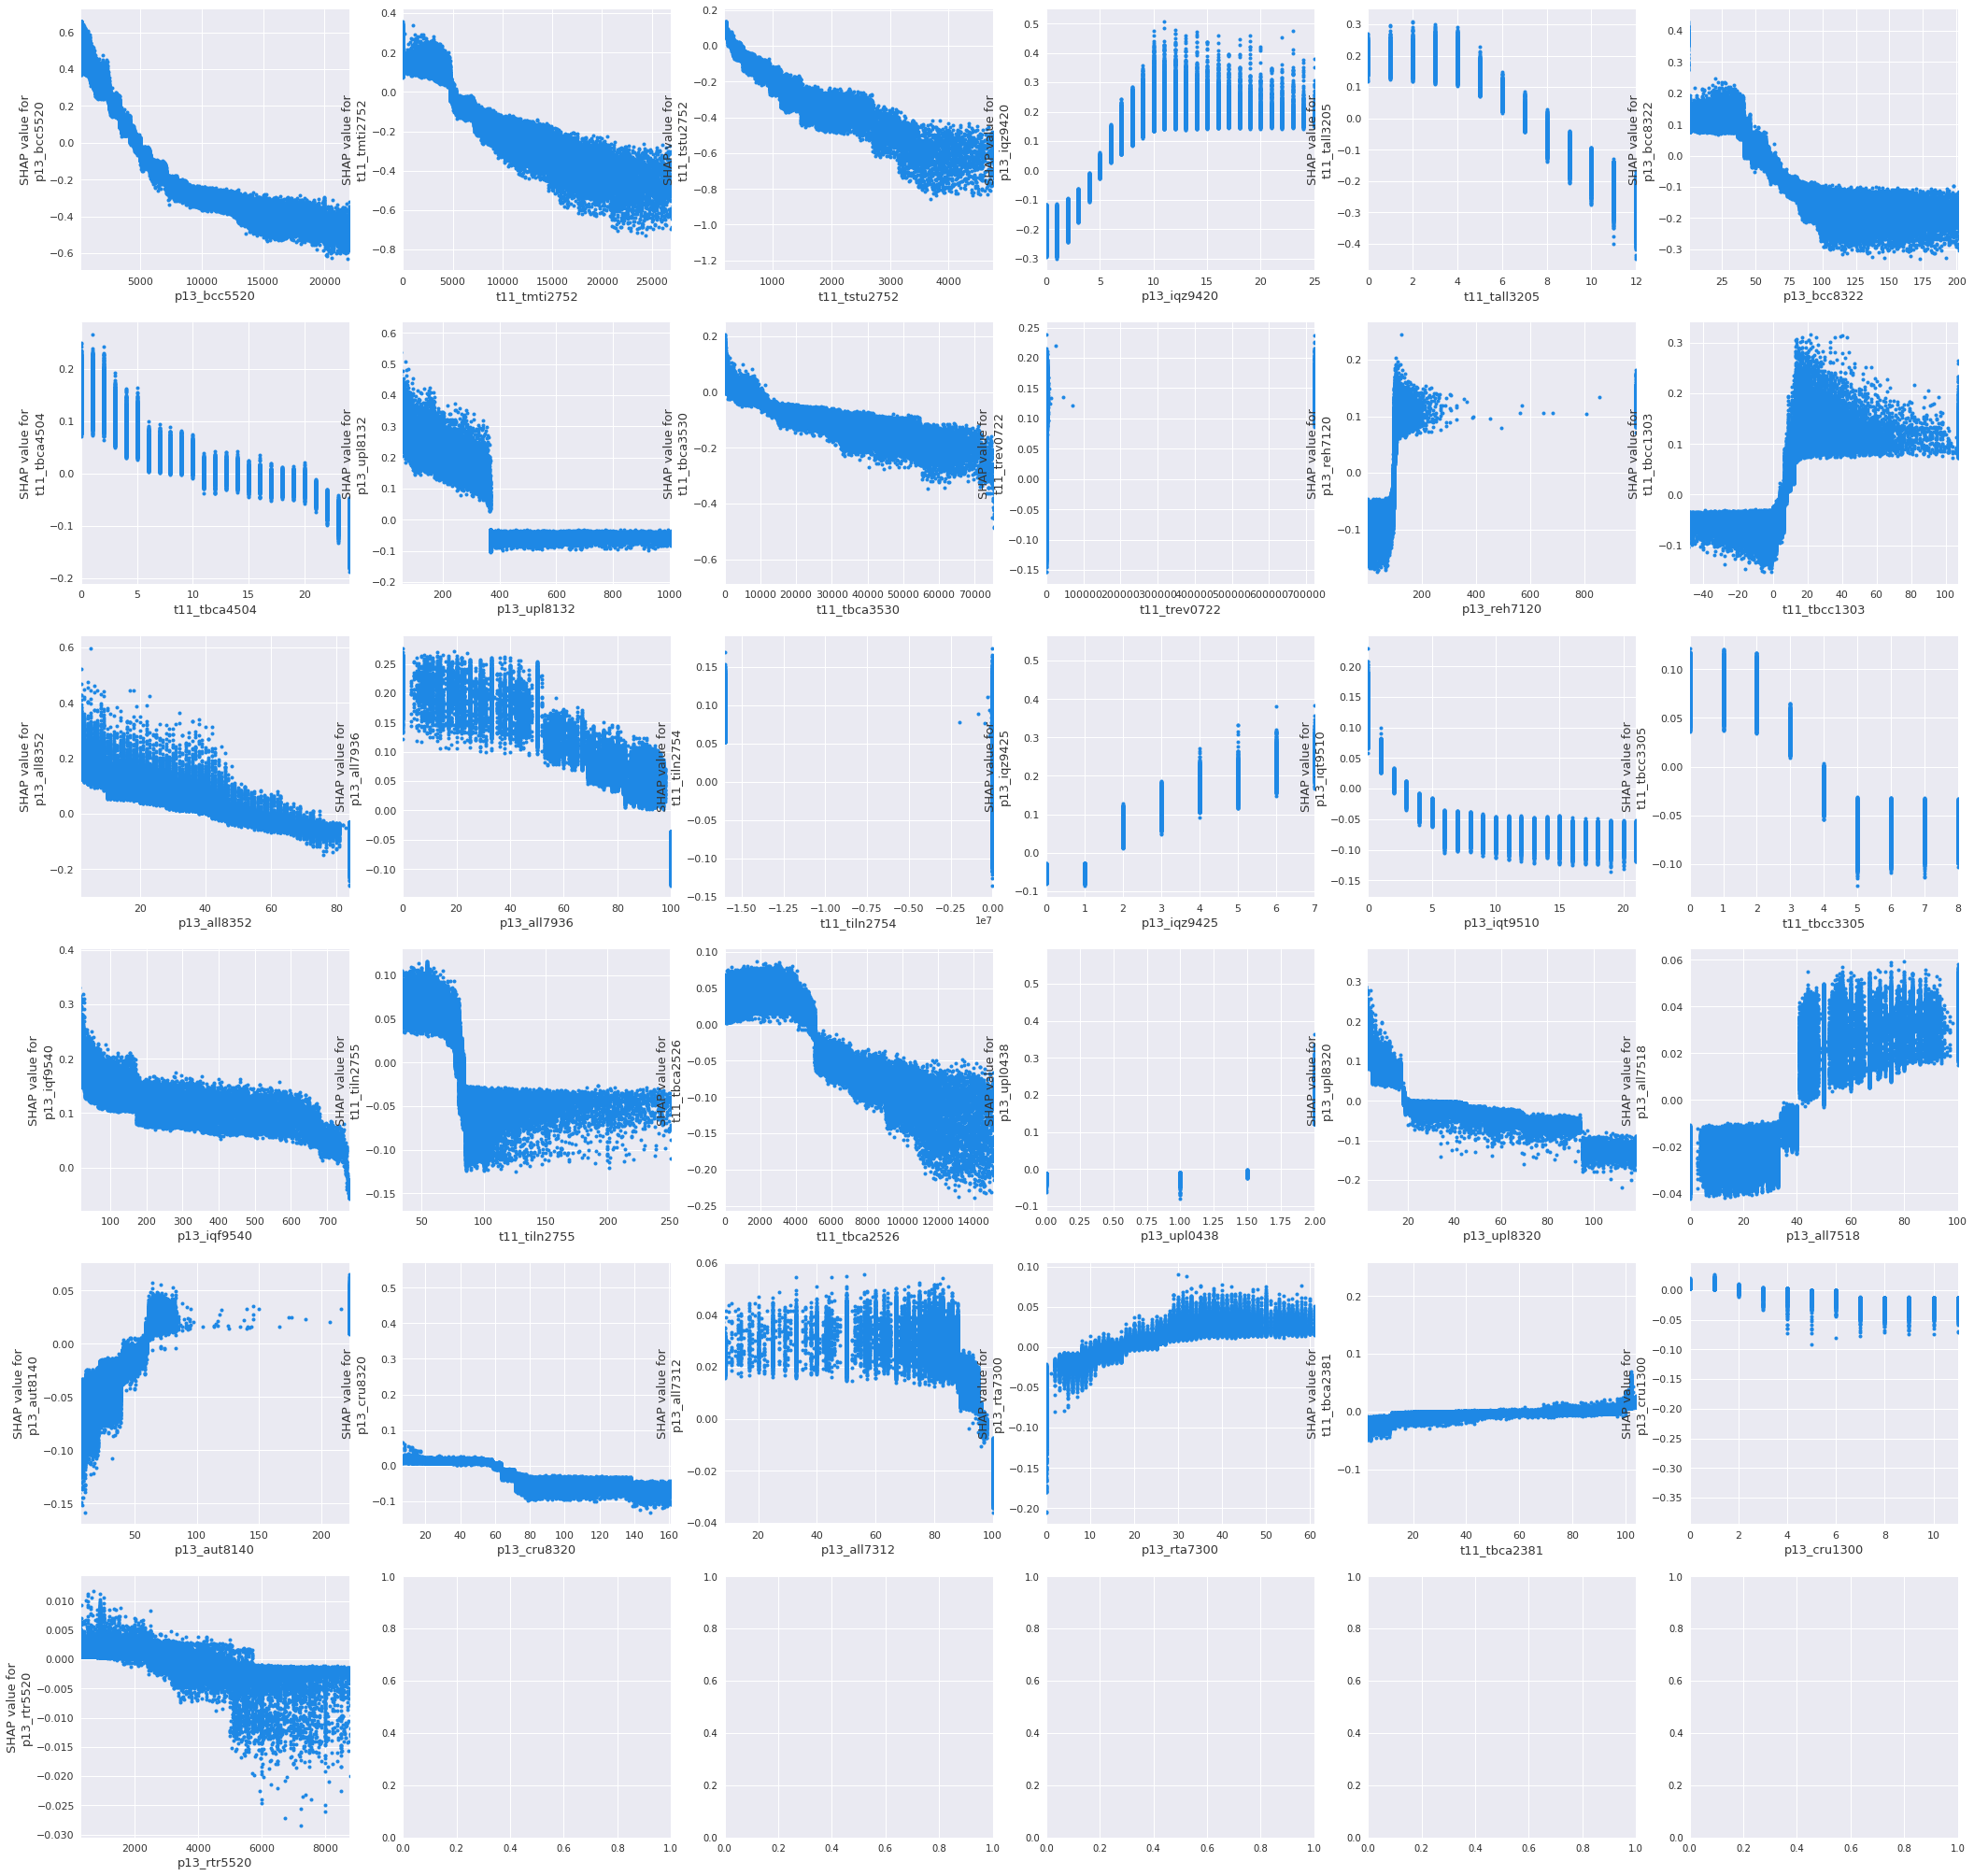

In [59]:
%time save_shap_dependence(model, sample_df, ft_by_shap, local_artifact_path, suffix="")

In [60]:
local_artifact_path

'../../artifacts/final_model/'

In [ ]:
1

#### Risk Sensitivity
---

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")


def get_risk_plot(df, label, preds, features, equal_width=False, 
                  ncols=6, figsize=None, weight=None, color='Blues_r', **kwargs):
    """
    Build the risk sensitivity plot for a set of models and features.
    """
    nrows = int(np.ceil(len(features) / ncols))
    if weight is None:
        df[weight] = 1

    if figsize is None:
        figsize = (ncols * 8, nrows * 8)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    if isinstance(preds, str):
        preds = [preds]
    for f, ax in zip(features, axs.flatten()):
        
        res = df.rename(columns={label:'actual'})
        cols = ['actual'] + preds
        if res[f].nunique()>10:
            res = res[(res[f] < res[f].quantile(0.99)) & (res[f] > res[f].quantile(0.01))]
            if equal_width:
                res = res.groupby(pd.cut(res[f], 10, duplicates='drop')).apply(lambda x: pd.Series(np.average(x[cols], weights = x[weight], axis=0), cols)).reset_index()
            else:
                res = res.groupby(pd.qcut(res[f], 10, duplicates='drop')).apply(lambda x: pd.Series(np.average(x[cols], weights = x[weight], axis=0), cols)).reset_index()
            res[f] = res[f].apply(lambda x: '({:.3f},{:.3f}]'.format(x.left, x.right) if x.right <= 1 
                                   else '({:.0f},{:.0f}]'.format(x.left, x.right))
        else:
            res = res.groupby(f).apply(lambda x: pd.Series(np.average(x[cols], weights = x[weight], axis=0), cols)).sort_values(by='actual').reset_index()

        res = pd.melt(res, id_vars=f, value_vars=cols, value_name=label)
        
        sns.lineplot(x=f, y=label, ax=ax, hue='variable', data=res, palette=color, ci=95)
        
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])

        ax.tick_params(axis='x', labelrotation=45)
        sns.despine()
    plt.tight_layout()
    plt.show()
    return fig, axs

In [ ]:
%%time
pred_cols = ["pred_gen4_prescreen"]

fig, axs = get_risk_plot(test_df, label="target", preds=pred_cols, equal_width=False,
              features=ft_by_shap, weight="weight_eval", color='coolwarm')
fig.savefig(os.path.join(local_artifact_path, "risk_sensitivity.png"))

#### Again, save everything to local
---